# Выявление закономерностей в продажах игр для интернет-магазина "Стримчик"

## Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Описание данных

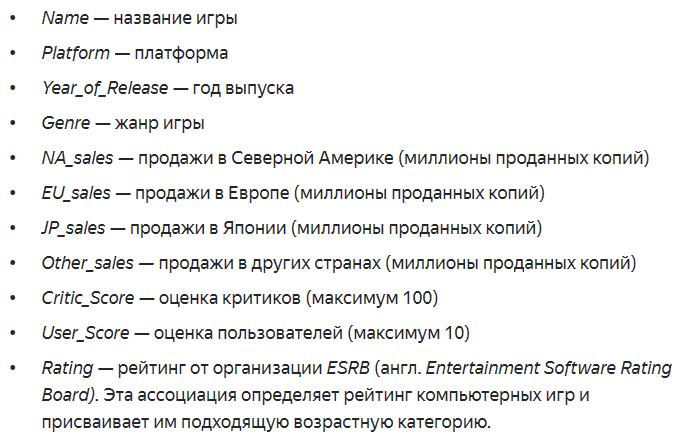

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
#импотритруем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from scipy import stats as st


In [2]:
#подгружаем файл с данными
try:
    df=pd.read_csv('games.csv')
except:
    df=pd.read_csv('/datasets/games.csv')


In [3]:
#изучим данные
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Перед нами датасет, который содержит 16715 строк и 11 столбцов. Изучим подробнее столбцы на пропуски и дубликаты, а также приведем некоторые столбцы к другому формату

### Шаг 2. Подготовьте данные

In [5]:
#привидем название всех столбцов к нижнему регистру
df.apply(lambda x: x.astype(str).str.lower())
df.rename(columns=lambda x: x.lower(), inplace=True)

In [6]:
#проверим на наличие пропусков
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

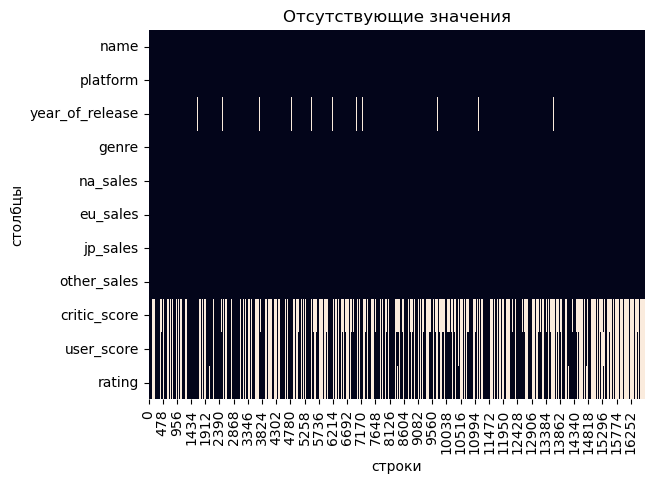

In [7]:
ax = plt.axes() 
sns.heatmap(df.isna().transpose(), cbar=False, ax=ax)
plt.title ('Отсутствующие значения') 
plt.xlabel ('строки') 
plt.ylabel ('столбцы')
plt.show()

Как видно основные пропуски приходятся на выставление оценки и общего рейтинга игры, просто так заменить это не получиться, так как тут нельзя вывести общую среднюю. Не значительное количество пропусков в столбце 'name', 'year_of_release' и 'genre' с ними и поработаем далее.

In [8]:
duplic=df[df.duplicated()]
duplic

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [9]:
df[df.duplicated(subset=['name','platform','year_of_release'], keep = False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Проверив на неявные дубликаты нашли строки с дублирующими значениями. строка с индексом 604 и 16230, и строка 659 и 14244. Удалим строки 659, 14244, 16230, так как они менее информативны

In [10]:
df=df.drop(index=[659,14244,16230])

In [11]:
#перепроверим еще раз
df[df.duplicated(subset=['name','platform','year_of_release'], keep = False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [12]:
df['name'].unique()

array(['Wii Sports', 'Super Mario Bros.', 'Mario Kart Wii', ...,
       'Woody Woodpecker in Crazy Castle 5', 'LMA Manager 2007',
       'Haitaka no Psychedelica'], dtype=object)

In [13]:
#Уберем лишние пробелы внутри ячейки и приведем к нижнему регистру
df['name']=df['name'].str.strip()
df['name']=df['name'].str.lower()

In [14]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [15]:
#проверим столбец 'platform' на уникальные значения
df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [16]:
#проверим столбец 'year_of_release' на уникальные значения
df['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Есть пропуски в столбце year_of_release - 269, это меньше 5% от всей информации, заменить тут не получиться, это столбец с датой, средним тут не заменишь, нули добавлять - исказит анализ. Удалим эти строки и приведем столбец к числовому формату

In [17]:
df.drop(df[df['year_of_release'].isna()].index,inplace=True)
df['year_of_release'] = pd.to_numeric(df['year_of_release'], downcast='integer')

In [18]:
#проверим столбец 'genre' на уникальные значения
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [19]:
#приведем к нижнему регистру
df['genre']=df['genre'].str.strip()
df['genre']=df['genre'].str.lower()

In [20]:
#убедимся что отсутствуют пропуски
df[df['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [21]:
#изучим столбец 'user_score'
df['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

In [22]:
df.loc[df['user_score'] == 'tbd','user_score'] = np.nan
df['user_score'] = df['user_score'].astype('float')

Столбец user_score содержит информацию об оценке пользователя на игру. Среди числовых оценок есть аббревиатура - 'tbd'('to be determined'- 'будет определено'). Очень часто подобное сокращение можно встретить в анонсах компьютерных игр в графе "Дата выхода". Когда разработчик той или иной игры уже сообщил о том, что она готовится к выходу, но пока еще не может назвать точную дату, именно это сокращение и используется. Получается пользователь знает об игре, но пока не играл в нее или она еще не вышла и дать оценку пока не может. По этой причине проще заменить это значение на пропуск, чтобы в дальнейшем не мешало при расчете.

In [23]:
#изучим столбец 'critic_score'
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [24]:
df['rating'].value_counts()

E       3920
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Рейтинг ESRB используется в таких странах как США и Канада, а игры выпускаются и продаться по всему миру, поэтому в данном датасете имеются пропуски в столбце 'rating'. Заменим эти пропуски заглушками

In [25]:
#на этом этапе можно заменить пропуски в данных. 
df['critic_score'] = df['critic_score'].fillna(-1)
df['user_score'] = df['user_score'].fillna(-1)
df['rating']=df['rating'].fillna('нет данных')

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>по твоей рекомендации применила заглушки    
</div>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Я рекоменовал поставить заглушки не на пропуски в колонках отзывов, а в колонке возрастного рейтинга. Но там это не сделано. Замена пропусков в отзывах на заглушку не является ошибкой, но далее при анализе отзывов их необходимо будет отфильтровывать.</font>

<div class="alert alert-info">
<b>Комментарий студента 2:</b>
<br>Добавила заглушки в столбец 'raiting'    
</div>

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int16  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
dtypes: float64(6), int16(1), object(4)
memory usage: 1.4+ MB


In [27]:
#посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец
df['total_sum']=df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']

In [28]:
#еще раз выведим данные 
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sum
0,wii sports,Wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,NES,1985,platform,29.08,3.58,6.81,0.77,-1.0,-1.0,нет данных,40.24
2,mario kart wii,Wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,Wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,GB,1996,role-playing,11.27,8.89,10.22,1.00,-1.0,-1.0,нет данных,31.38


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int16  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  total_sum        16443 non-null  float64
dtypes: float64(7), int16(1), object(4)
memory usage: 1.5+ MB


В столбце user_score имеет количественные переменные. "to be defined" - это отсутствие оценки на момент выгрузки данных. Чтобы было удобнее работать с данными заменили 'tbd' на заглушки. Пропуски в столбцах name и genre. Это строки 659 и 14244. По году и платформе видно. Что это одна и также игра, только в одной строке храниться данные о продажах в Европе и Америке, а во второй - только по Японии. Так же есть дубликаты в строках 604 и 16230. Удалили строку 16230 так как там меньше информации. Пропуск в столбце year_of_release. Аггрегатор игр мог и не получить информацию от создателей или издателей игр. Пропуски в столбцах critic_score, user_score и rating. Не все игры получают быструю оценку, в зависимости от стран оценки разняться. Из-за этого в большинстве случаев отсутствуют оценки игроков или ESRB оценка. Итак мы подготовили данные для дальнейшего анализа, удалили пропуски, привели столбец 'year_of_release' к числовому формату, проверили на наличие дубликатов. Так же добавили столбец 'total_sum', где отображены суммарные продажи по всем регионам.

In [30]:
# Комментарий ревьюера
# Посмотрим, что осталось
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int16  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  total_sum        16443 non-null  float64
dtypes: float64(7), int16(1), object(4)
memory usage: 1.5+ MB
None
-------------------------
name ["'98 koshien" '.hack//g.u. vol.1//rebirth' '.hack//g.u. vol.2//reminisce'
 ... 'zwei!!' 'zyuden sentai kyoryuger: game de gaburincho!!'
 '¡shin chan

### Шаг 3. Проведите исследовательский анализ данных

*Посмотрите, сколько игр выпускалось в разные годы*

,count
,name
year_of_release,
2008,1427
2009,1426
2010,1255
2007,1197
2011,1136
2006,1006
2005,939
2002,829


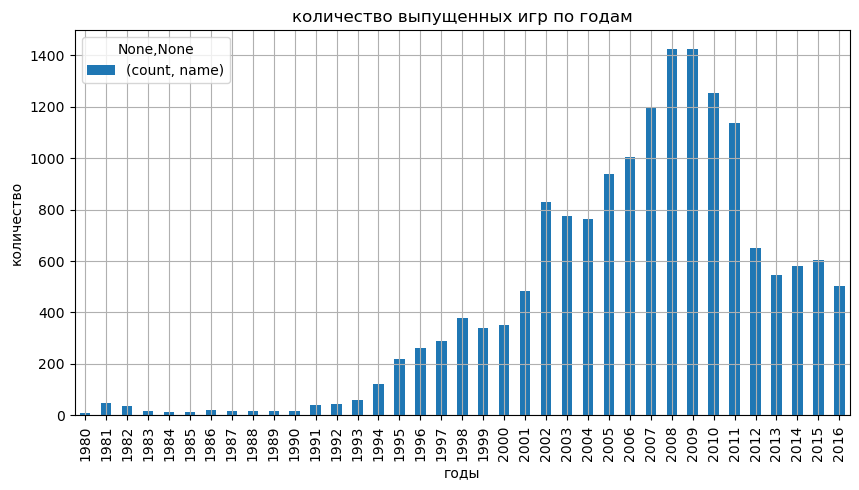

In [31]:
box_office_year=df.pivot_table(index='year_of_release',values='name', aggfunc=['count'])\
.sort_values(('count','name'),ascending=False)
display(box_office_year)
box_office_year.sort_values(by='year_of_release').plot(kind='bar',figsize = (10, 5),grid=True)
plt.title('количество выпущенных игр по годам')
plt.xlabel('годы')
plt.ylabel('количество')
plt.show()

*Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам.*

In [32]:
platform_pivot_table = pd.pivot_table(df, index=['platform'], values='total_sum', aggfunc='sum')
platform_pivot_table = platform_pivot_table.sort_values('total_sum',ascending=False)
platform_pivot_table

,total_sum
platform,
PS2,1233.56
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [33]:
#выведем в отдельный фрейм топ-10 платформ
best_sales_platform = list(platform_pivot_table.index[:10])
best_sales_platform

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']

In [34]:
top_platform_df = df.query('platform == ["PS2", "X360", "PS3", "Wi", "DS", "PS", "PS4", "GBA", "PSP", "3DS"]')

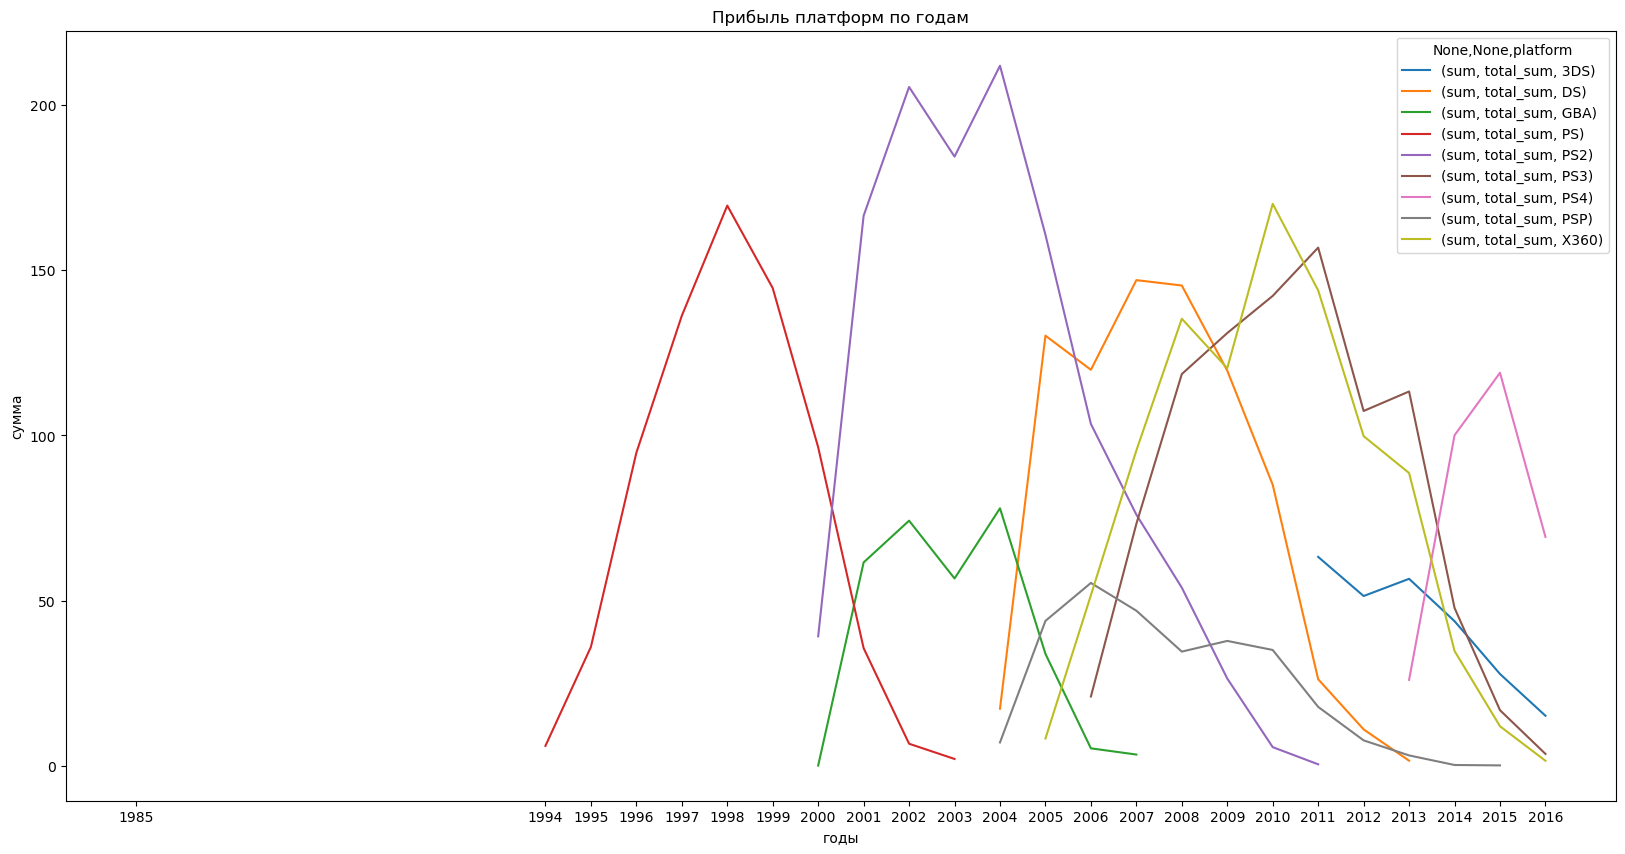

In [35]:
#построим сводную таблицу для новой df
top_platforms =top_platform_df.pivot_table(
                                 index = ['year_of_release'], \
                                 columns = ['platform'],
                                 values = ['total_sum'],
                                 aggfunc =  ['sum'])
top_platforms.plot(figsize = (20,10))
plt.title('Прибыль платформ по годам')
plt.xlabel('годы')
plt.ylabel('сумма')
plt.xticks(top_platforms.index)
plt.show()

Исходя из получившегося графика, видно что жизненный цикл платформы в среднем 8-10 лет, нам нужно выбрать данные за такой период чтобы на основе них построить прогноз на 2017 год. Возьмем за актуальный период промежуток с 2007 года.

In [36]:
# Комментарий ревьюера
temp = df.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

*Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.*

Исходя из того что рынок падающий возьмем за актуальный период 2012-2016 год

In [37]:
#сохраним актуальную таблицу и далее будем работать с ней
new_df = df.query('year_of_release >= 2012')
new_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sum
16,grand theft auto v,PS3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,grand theft auto v,X360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,call of duty: black ops 3,PS4,2015,shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,нет данных,14.63
33,pokemon x/pokemon y,3DS,2013,role-playing,5.28,4.19,4.35,0.78,-1.0,-1.0,нет данных,14.60
34,call of duty: black ops ii,PS3,2012,shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


*Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.*

In [38]:
#построим сводную таблицу для новой df
top_platforms_new =new_df.pivot_table(
                                 index = ['platform'], \
                                 values = ['total_sum'],
                                 aggfunc =  ['sum'])
top_platforms_new.sort_values(('sum', 'total_sum'),ascending = False)


,sum
,total_sum
platform,
PS4,314.14
PS3,288.78
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18


По продажам лидируют PS4, PS3, X360, 3DS, XOne. Посмотрим на какой "стадии жизни" находятся все платформы

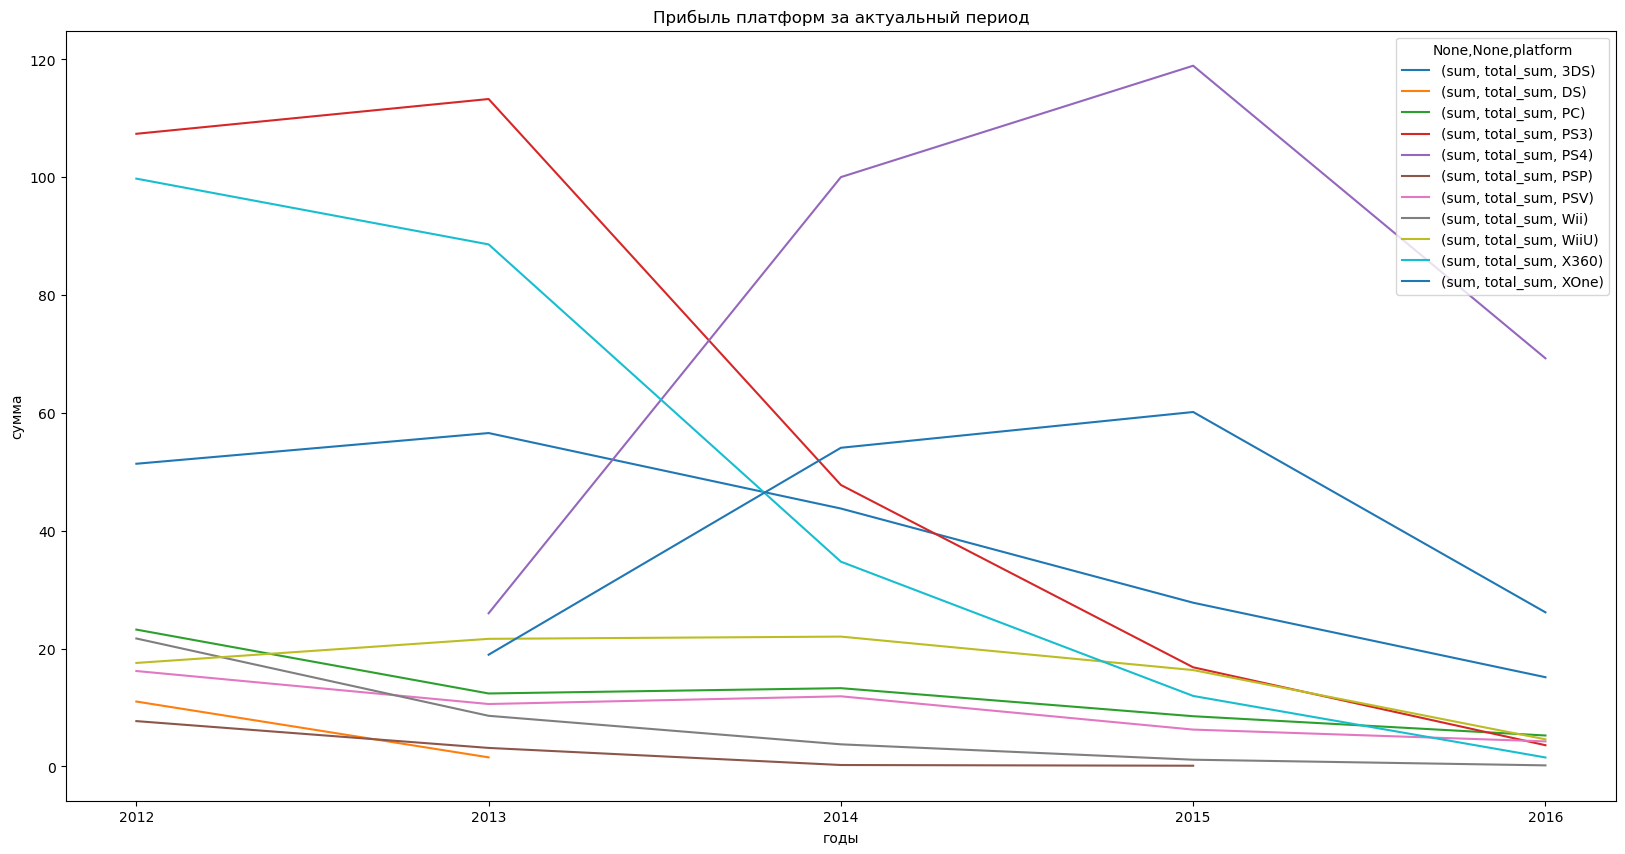

In [39]:
top_platforms_new =new_df.pivot_table(
                                 index = ['year_of_release'], \
                                 columns = ['platform'],
                                 values = ['total_sum'],
                                 aggfunc =  ['sum'])
top_platforms_new.plot(figsize = (20,10))
plt.title('Прибыль платформ за актуальный период')
plt.xlabel('годы')
plt.ylabel('сумма')
plt.xticks(top_platforms_new.index)

plt.show()

Большинство платформ "идут к закату". Но есть 2 потенциально прибыльные платформы: PS4 и XOne

*Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам.*

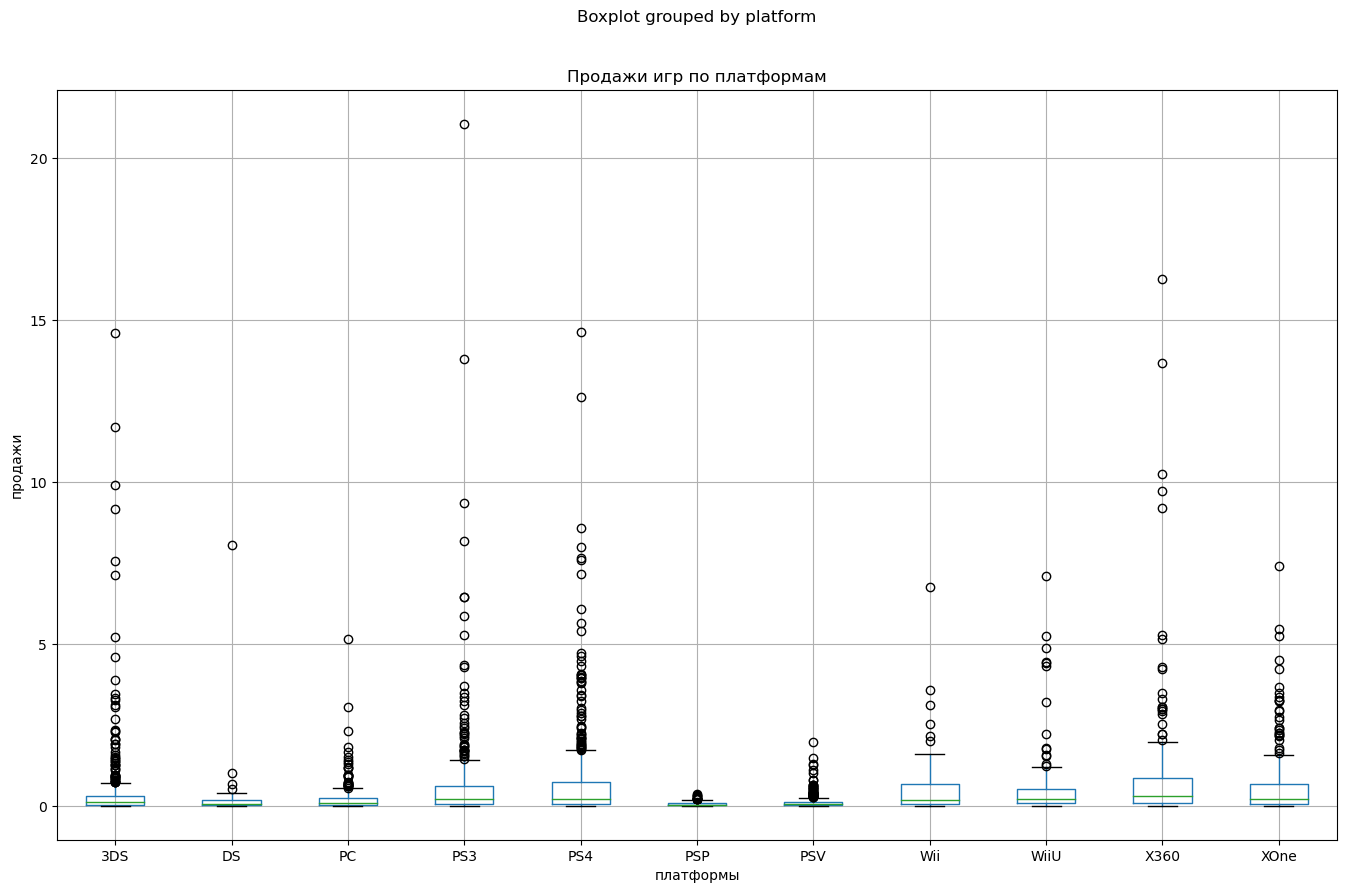

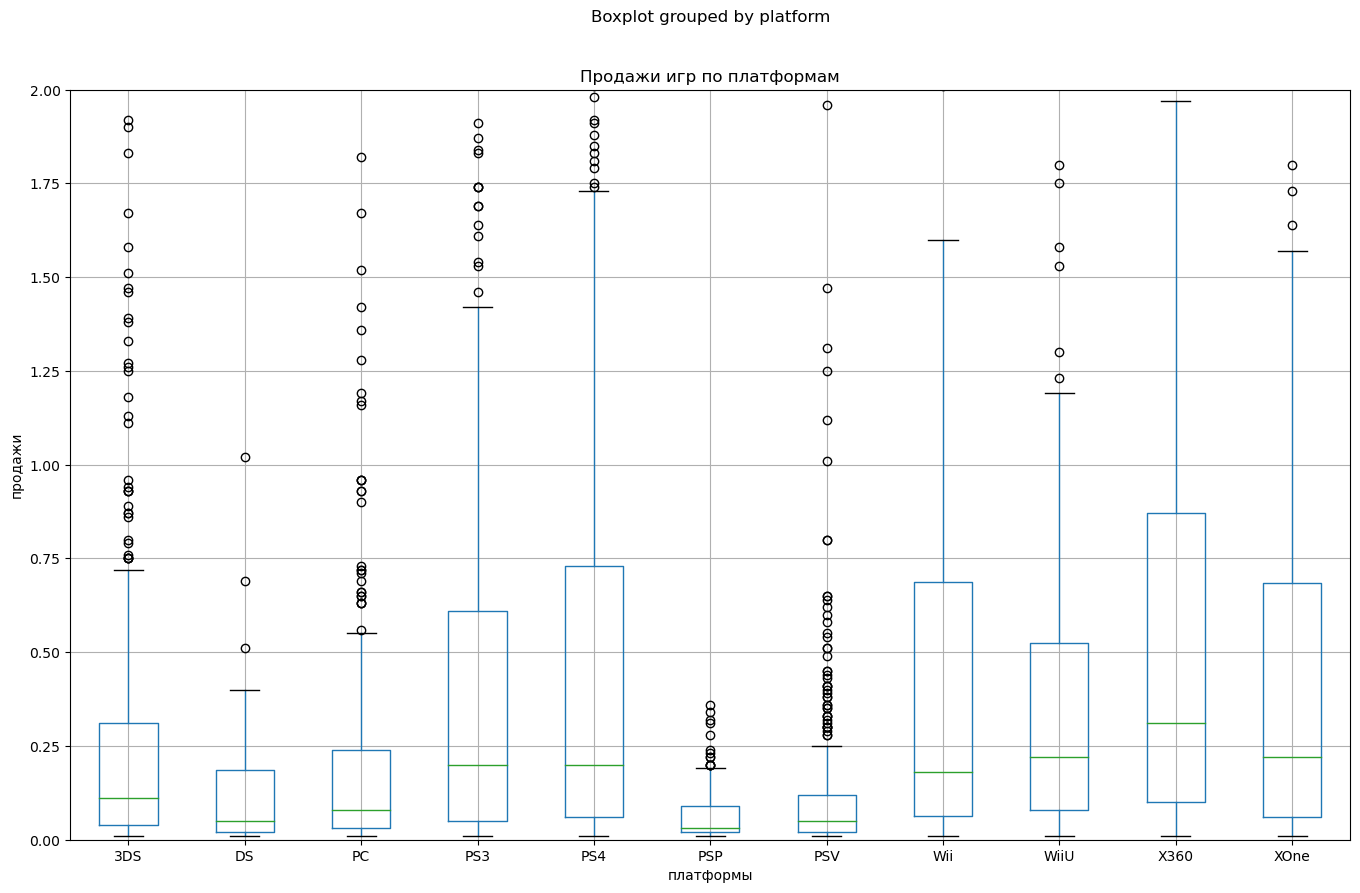

In [40]:
new_df.boxplot(column = ['total_sum'],by = ['platform'],figsize=(16, 10)).set(title = 'Продажи игр по платформам', 
         xlabel = 'платформы', ylabel = 'продажи')
plt.show()


new_df.boxplot(column = ['total_sum'],by = ['platform'],figsize=(16, 10)).set(title = 'Продажи игр по платформам', 
         xlabel = 'платформы', ylabel = 'продажи')
plt.ylim([0, 2])
plt.show()



<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>Исправила 
</div>

Рассмотрев медиану по всем платформам, можно сказать, что наиболее стабильно высокие продажи у таких платформ как - X360, XOne, WiiU, PS3, PS4. Далее рассмотрим как влияют отзывы критиков и пользователей на продажи внутри платформы.

*Посмотим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.* 

**Платформа X360**

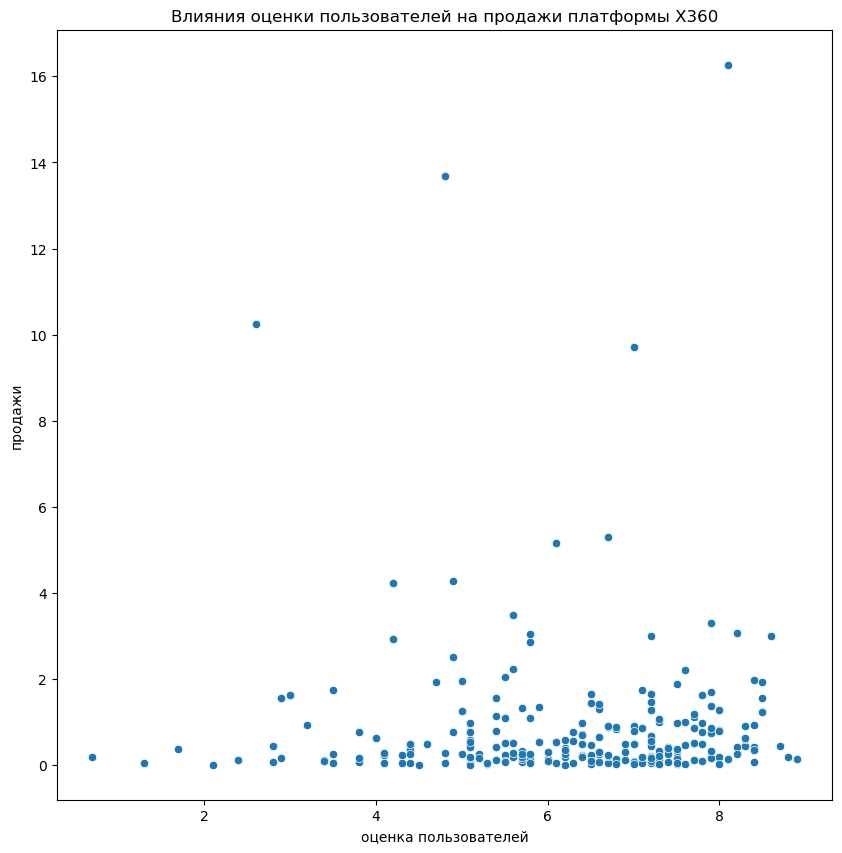

In [41]:
X360=new_df.query('platform=="X360"')

# Фильтрация данных по отзывам пользователей без заглушек
X360_user_reviews = X360[X360['user_score'] != -1]

# Сортировка данных
X360_user_reviews = X360_user_reviews.sort_values('user_score', ascending=False)

# Создание диаграммы рассеяния
X360_user_score = sns.scatterplot(data=X360_user_reviews, x='user_score', y='total_sum')
X360_user_score.figure.set_figwidth(10)
X360_user_score.figure.set_figheight(10)
X360_user_score.set_xlabel('оценка пользователей')
X360_user_score.set_ylabel('продажи')
X360_user_score.set_title('Влияния оценки пользователей на продажи платформы X360')
plt.show()

In [42]:
#посчитаем коэффициент корреляции 
correlation_coefficient = X360_user_reviews['user_score'].corr(X360_user_reviews['total_sum'])
print(f"Коэффициент корреляции: {correlation_coefficient}")

Коэффициент корреляции: 0.006163978646213355


Коэффициент корреляции равен 0.006, это означает что нет никакого влияния оценок пользователей на продажи игр на платформе X360 

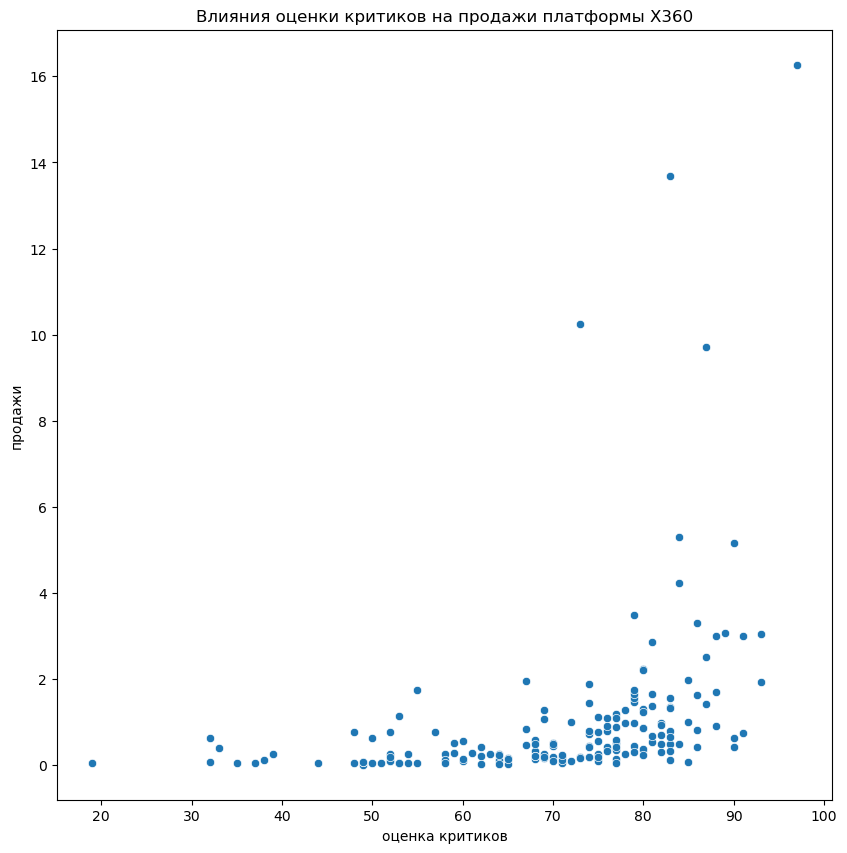

In [43]:
# Фильтрация данных по отзывам критиков без заглушек
X360_critic_reviews = X360[X360['critic_score'] != -1]

# Сортировка данных
X360_critic_reviews = X360_critic_reviews.sort_values('critic_score', ascending=False)

#посмотрим на связь оценок критиков и продажами
X360_critic_score = sns.scatterplot(data = X360_critic_reviews, x = 'critic_score',y = 'total_sum')
X360_critic_score.figure.set_figwidth(10)
X360_critic_score.figure.set_figheight(10)
X360_critic_score.set_xlabel('оценка критиков')
X360_critic_score.set_ylabel('продажи')
X360_critic_score.set_title('Влияния оценки критиков на продажи платформы X360')
plt.show()

In [44]:
#посчитаем коэффициент корреляции 
correlation_coefficient =X360_critic_reviews['critic_score'].corr(X360_critic_reviews['total_sum'])
print(f"Коэффициент корреляции: {correlation_coefficient}")

Коэффициент корреляции: 0.3605734888507334


Коэффициент корреляции 0.36 - тут более существеннная зависимость влияния оценок критиков на продажи игр на платформе X360.

**Платформа XOne** 

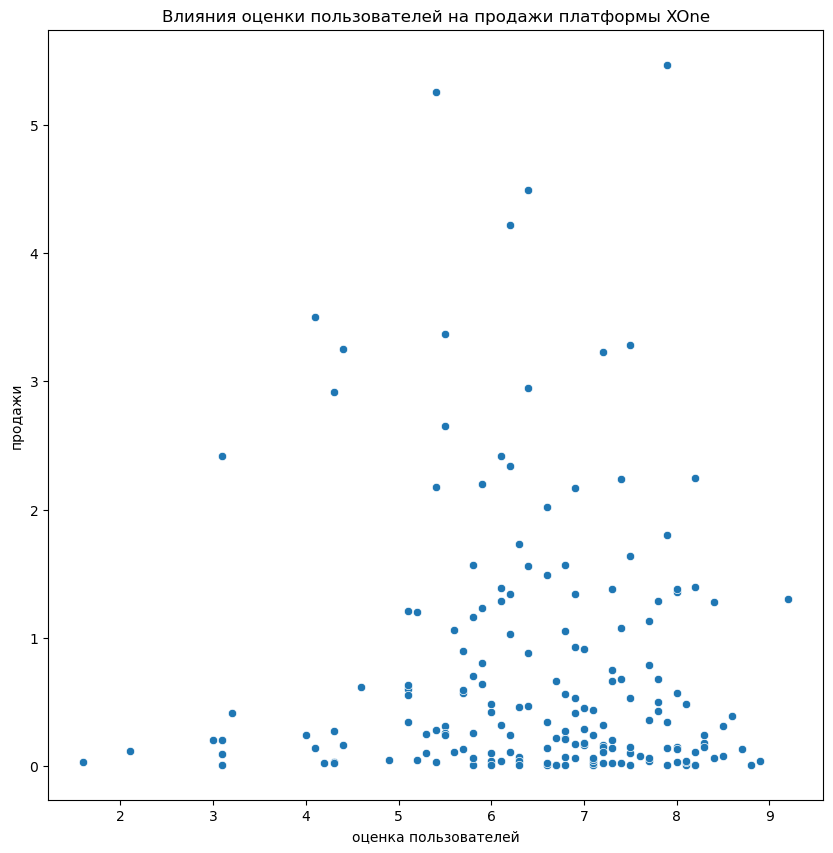

In [45]:
#платформа XOne
XOne=new_df.query('platform=="XOne"')

# Фильтрация данных по отзывам пользователей без заглушек
XOne_user_reviews =XOne[XOne['user_score'] != -1]

# Сортировка данных
XOne_user_reviews = XOne_user_reviews.sort_values('user_score', ascending=False)

# Создание диаграммы рассеяния
XOne_user_score = sns.scatterplot(data=XOne_user_reviews, x='user_score', y='total_sum')
XOne_user_score.figure.set_figwidth(10)
XOne_user_score.figure.set_figheight(10)
XOne_user_score.set_xlabel('оценка пользователей')
XOne_user_score.set_ylabel('продажи')
XOne_user_score.set_title('Влияния оценки пользователей на продажи платформы XOne')
plt.show()

In [46]:
#посчитаем коэффициент корреляции 
correlation_coefficient =XOne_user_reviews['user_score'].corr(XOne_user_reviews['total_sum'])
print(f"Коэффициент корреляции: {correlation_coefficient}")

Коэффициент корреляции: -0.06892505328279423


Коэффициент корреляции равен -0.06, это означает что нет никакого влияния оценок пользователей на продажи игр на платформе XOne

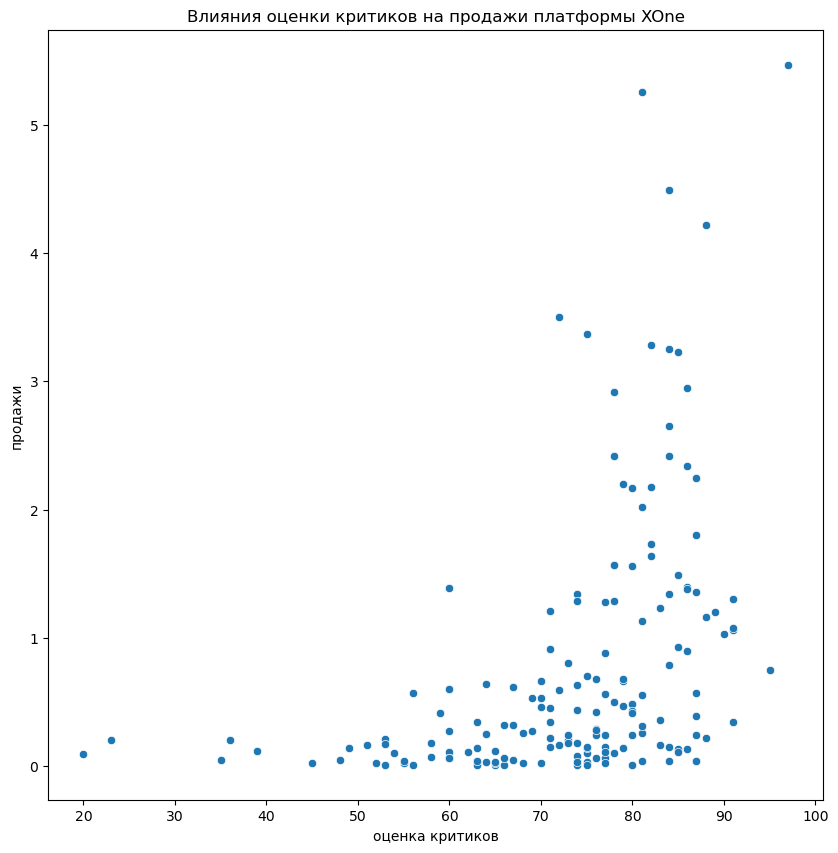

In [47]:
# Фильтрация данных по отзывам критиков без заглушек
XOne_critic_reviews =XOne[XOne['critic_score'] != -1]

# Сортировка данных
XOne_critic_reviews = XOne_critic_reviews.sort_values('critic_score', ascending=False)

# Создание диаграммы рассеяния
XOne_critic_score = sns.scatterplot(data=XOne_critic_reviews, x='critic_score', y='total_sum')
XOne_critic_score.figure.set_figwidth(10)
XOne_critic_score.figure.set_figheight(10)
XOne_critic_score.set_xlabel('оценка критиков')
XOne_critic_score.set_ylabel('продажи')
XOne_critic_score.set_title('Влияния оценки критиков на продажи платформы XOne')
plt.show()

In [48]:
#посчитаем коэффициент корреляции 
correlation_coefficient =XOne_critic_reviews['critic_score'].corr(XOne_critic_reviews['total_sum'])
print(f"Коэффициент корреляции: {correlation_coefficient}")

Коэффициент корреляции: 0.41699832800840175


Коэффициент корреляции 0.41 - тут более существеннная зависимость влияния оценок критиков на продажи игр на платформе XOne.

**Платформа WiiU** 

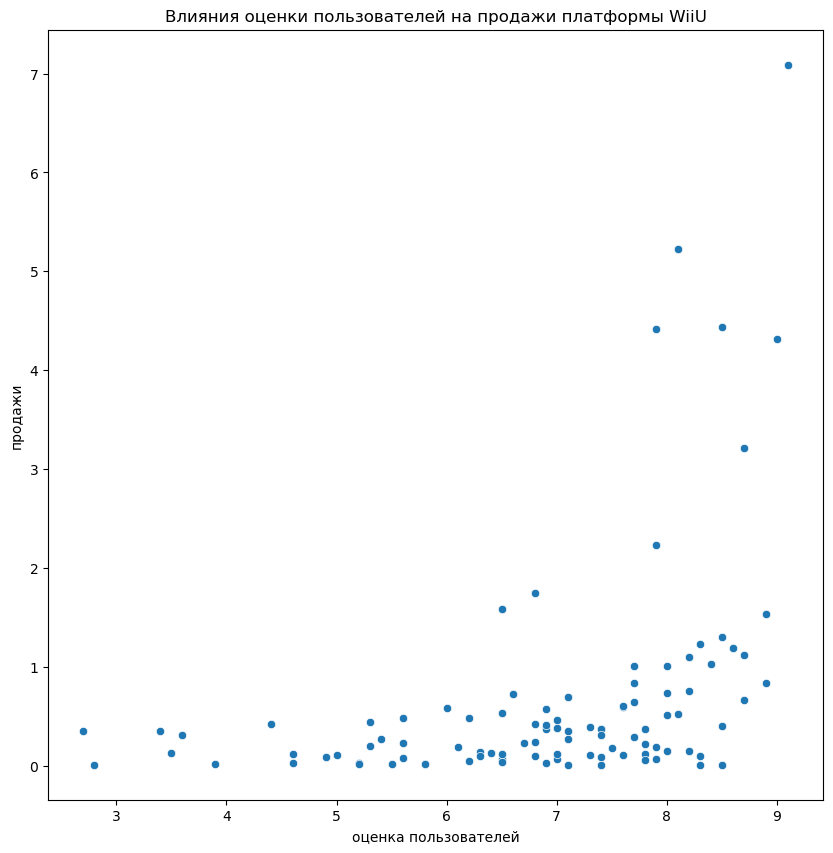

In [49]:
#платформа WiiU
WiiU=new_df.query('platform=="WiiU"')

# Фильтрация данных по отзывам пользователей без заглушек
WiiU_user_reviews =WiiU[WiiU['user_score'] != -1]

# Сортировка данных
WiiU_user_reviews = WiiU_user_reviews.sort_values('user_score', ascending=False)

# Создание диаграммы рассеяния
WiiU_user_score = sns.scatterplot(data=WiiU_user_reviews, x='user_score', y='total_sum')
WiiU_user_score.figure.set_figwidth(10)
WiiU_user_score.figure.set_figheight(10)
WiiU_user_score.set_xlabel('оценка пользователей')
WiiU_user_score.set_ylabel('продажи')
WiiU_user_score.set_title('Влияния оценки пользователей на продажи платформы WiiU')
plt.show()

In [50]:
#посчитаем коэффициент корреляции 
correlation_coefficient =WiiU_user_reviews['user_score'].corr(WiiU_user_reviews['total_sum'])
print(f"Коэффициент корреляции: {correlation_coefficient}")

Коэффициент корреляции: 0.40021902021486155


Коэффициент корреляции 0.40 - в отличие от предыдущих платформ тут существеннная зависимость влияния оценок пользователей на продажи игр на платформе WiiU.

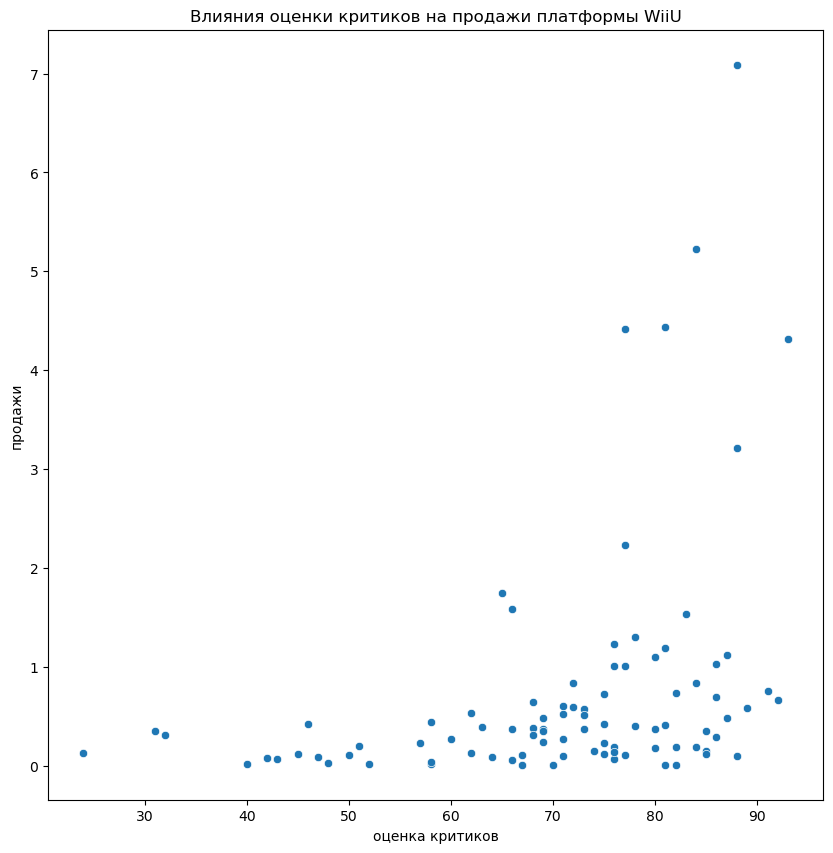

In [51]:
# Фильтрация данных по отзывам критиков без заглушек
WiiU_critic_reviews =WiiU[WiiU['critic_score'] != -1]

# Сортировка данных
WiiU_critic_reviews = WiiU_critic_reviews.sort_values('critic_score', ascending=False)

# Создание диаграммы рассеяния
WiiU_critic_score = sns.scatterplot(data=WiiU_critic_reviews, x='critic_score', y='total_sum')
WiiU_critic_score.figure.set_figwidth(10)
WiiU_critic_score.figure.set_figheight(10)
WiiU_critic_score.set_xlabel('оценка критиков')
WiiU_critic_score.set_ylabel('продажи')
WiiU_critic_score.set_title('Влияния оценки критиков на продажи платформы WiiU')
plt.show()

In [52]:
#посчитаем коэффициент корреляции 
correlation_coefficient =WiiU_user_reviews['critic_score'].corr(WiiU_user_reviews['total_sum'])
print(f"Коэффициент корреляции: {correlation_coefficient}")

Коэффициент корреляции: 0.32852162582908717


А вот коэфициент корреляции зависимости оценок критиков и продаж тут ниже чем коэфициент корреляции зависимости оценок пользователей. Составляет 0.32. 

**Платформа PS3** 

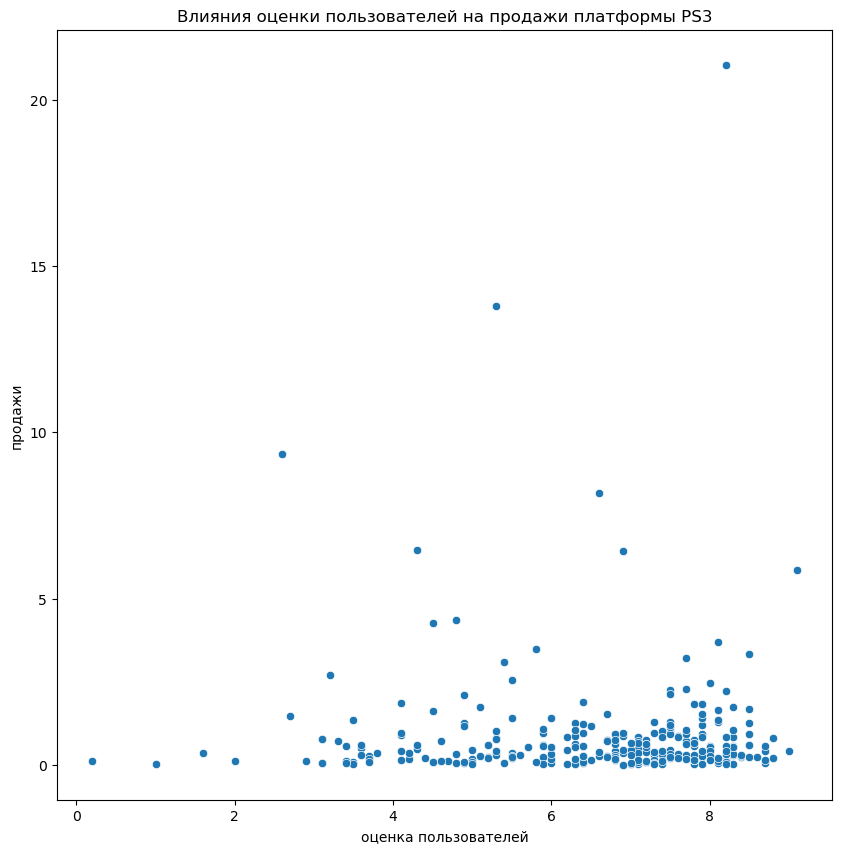

In [53]:
#платформа PS3
PS3=new_df.query('platform=="PS3"')

# Фильтрация данных по отзывам пользователей без заглушек
PS3_user_reviews =PS3[PS3['user_score'] != -1]

# Сортировка данных
PS3_user_reviews = PS3_user_reviews.sort_values('user_score', ascending=False)

# Создание диаграммы рассеяния
PS3_user_score = sns.scatterplot(data=PS3_user_reviews, x='user_score', y='total_sum')
PS3_user_score.figure.set_figwidth(10)
PS3_user_score.figure.set_figheight(10)
PS3_user_score.set_xlabel('оценка пользователей')
PS3_user_score.set_ylabel('продажи')
PS3_user_score.set_title('Влияния оценки пользователей на продажи платформы PS3')
plt.show()

In [54]:
#посчитаем коэффициент корреляции 
correlation_coefficient =PS3_user_reviews['user_score'].corr(PS3_user_reviews['total_sum'])
print(f"Коэффициент корреляции: {correlation_coefficient}")

Коэффициент корреляции: -0.006205767686051512


Коэффициент корреляции -0.006, практически отсутствует зависимость между оценкой пользователей и показателями продаж.

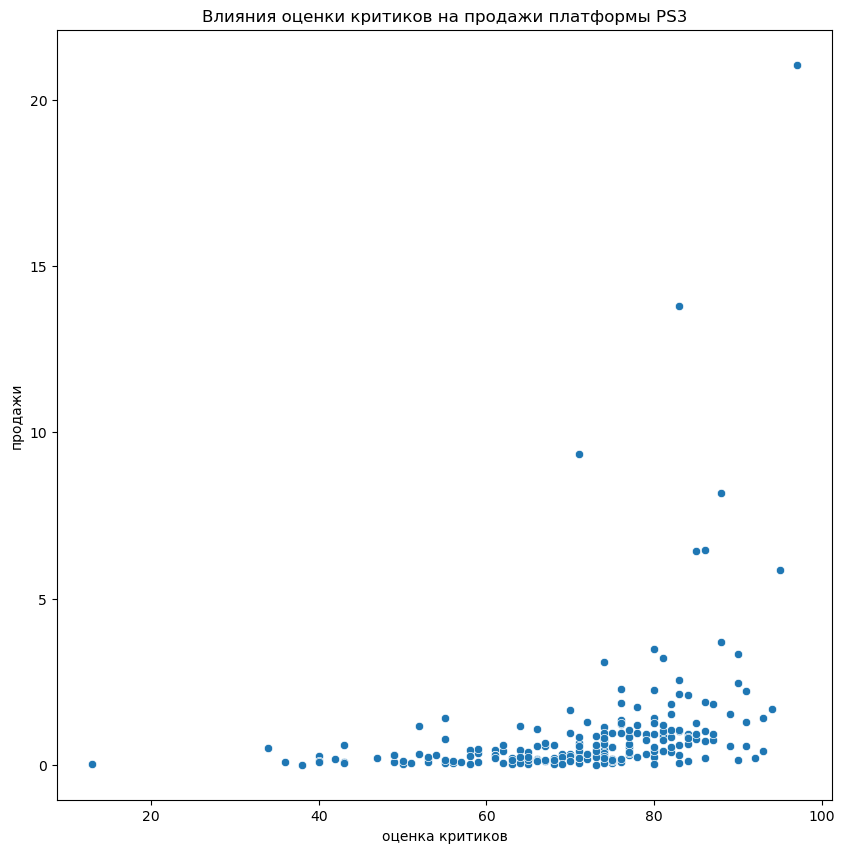

In [55]:
# Фильтрация данных по отзывам критиков без заглушек
PS3_critic_reviews =PS3[PS3['critic_score'] != -1]

# Сортировка данных
PS3_critic_reviews = PS3_critic_reviews.sort_values('critic_score', ascending=False)

# Создание диаграммы рассеяния
PS3_critic_score = sns.scatterplot(data=PS3_critic_reviews, x='critic_score', y='total_sum')
PS3_critic_score.figure.set_figwidth(10)
PS3_critic_score.figure.set_figheight(10)
PS3_critic_score.set_xlabel('оценка критиков')
PS3_critic_score.set_ylabel('продажи')
PS3_critic_score.set_title('Влияния оценки критиков на продажи платформы PS3')
plt.show()

In [56]:
#посчитаем коэффициент корреляции 
correlation_coefficient =PS3_critic_reviews['critic_score'].corr(PS3_critic_reviews['total_sum'])
print(f"Коэффициент корреляции: {correlation_coefficient}")

Коэффициент корреляции: 0.33415175755098564


Тут наблюдаеться зависимость, коэффициент корреляции 0.33, между оценкой критиков и продажами по платформе PS3. 

**Платформа PS4** 

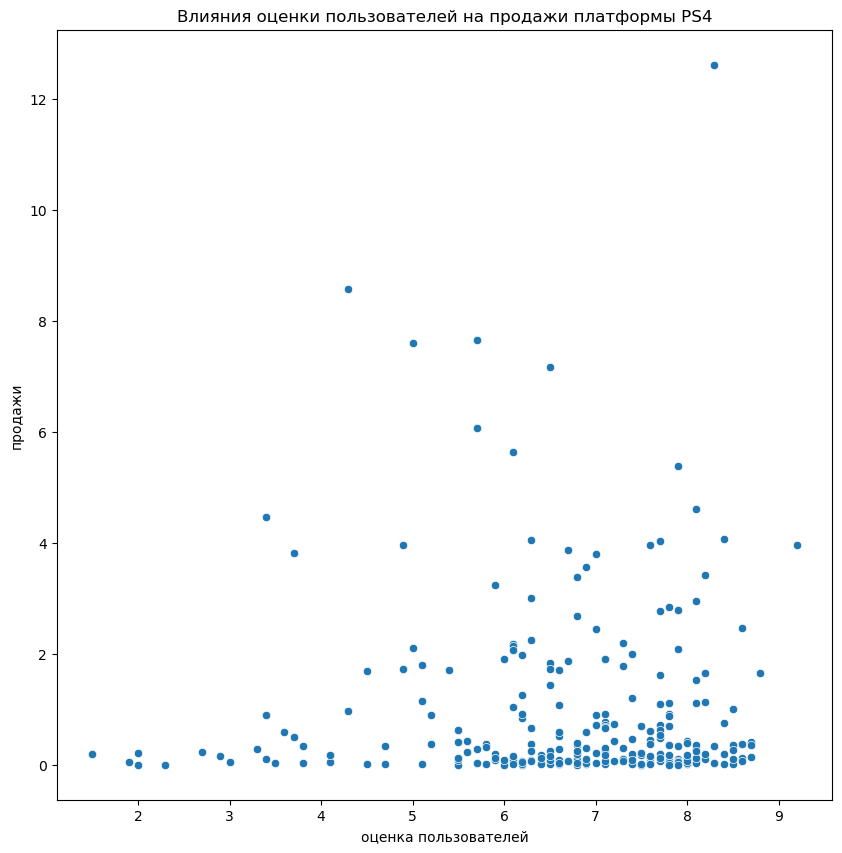

In [57]:
#платформа PS3
PS4=new_df.query('platform=="PS4"')

# Фильтрация данных по отзывам пользователей без заглушек
PS4_user_reviews =PS4[PS4['user_score'] != -1]

# Сортировка данных
PS4_user_reviews = PS4_user_reviews.sort_values('user_score', ascending=False)

#посмотрим диаграммы рассеяния влияния отзывов пользователей на продажи
PS4_user_score = sns.scatterplot(data = PS4_user_reviews, x = 'user_score',y = 'total_sum')
PS4_user_score.figure.set_figwidth(10)
PS4_user_score.figure.set_figheight(10)
PS4_user_score.set_xlabel('оценка пользователей')
PS4_user_score.set_ylabel('продажи')
PS4_user_score.set_title('Влияния оценки пользователей на продажи платформы PS4')
plt.show()

In [58]:
#посчитаем коэффициент корреляции 
correlation_coefficient =PS4_user_reviews['user_score'].corr(PS4_user_reviews['total_sum'])
print(f"Коэффициент корреляции: {correlation_coefficient}")

Коэффициент корреляции: -0.03195711020455644


Коэффициент корреляции равен -0.03, прямого влияния оценок пользователей на продажи игр на платформе PS4 нет.

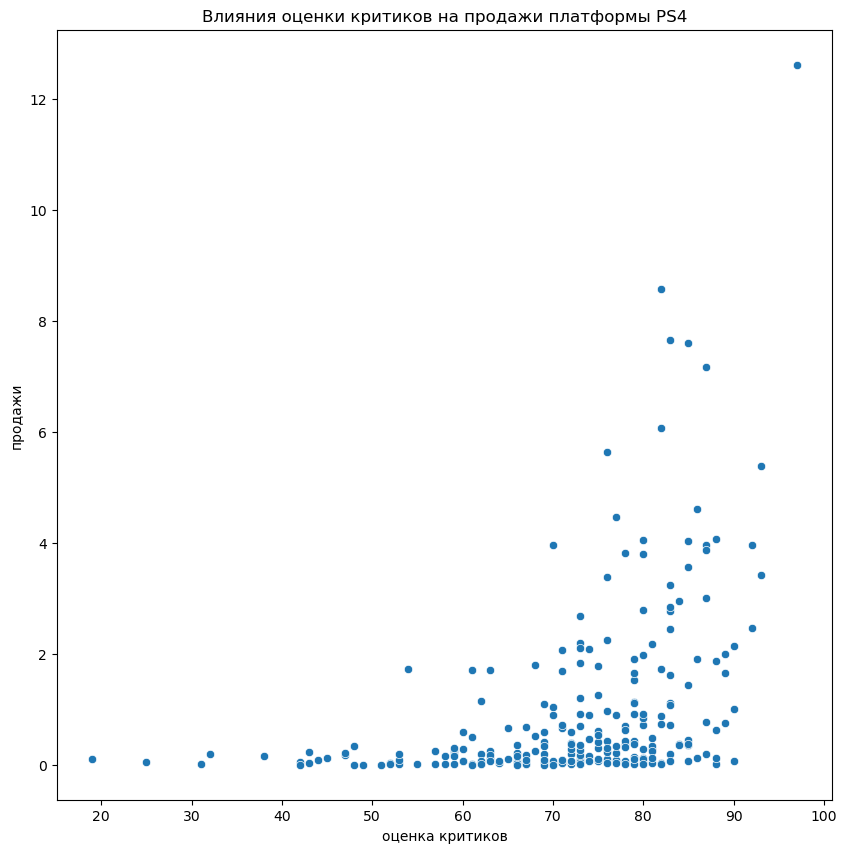

In [59]:
# Фильтрация данных по отзывам критиков без заглушек
PS4_critic_reviews =PS4[PS4['critic_score'] != -1]

# Сортировка данных
PS4_critic_reviews = PS4_critic_reviews.sort_values('critic_score', ascending=False)

#посмотрим диаграммы рассеяния влияния отзывов критиков на продажи
PS4_critic_score = sns.scatterplot(data = PS4_critic_reviews, x = 'critic_score',y = 'total_sum')
PS4_critic_score.figure.set_figwidth(10)
PS4_critic_score.figure.set_figheight(10)
PS4_critic_score.set_xlabel('оценка критиков')
PS4_critic_score.set_ylabel('продажи')
PS4_critic_score.set_title('Влияния оценки критиков на продажи платформы PS4')
plt.show()

In [60]:
#посчитаем коэффициент корреляции 
correlation_coefficient =PS4_critic_reviews['critic_score'].corr(PS4_critic_reviews['total_sum'])
print(f"Коэффициент корреляции: {correlation_coefficient}")

Коэффициент корреляции: 0.4065679020617811


Расчет по Платформе 3DS


user_score    0.197583
total_sum     1.000000
Name: total_sum, dtype: float64

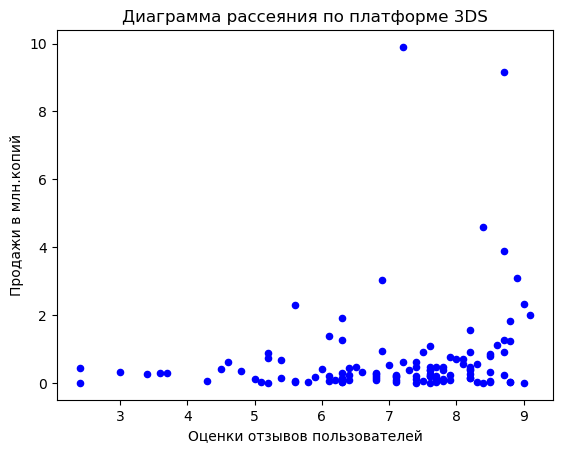

critic_score    0.320803
total_sum       1.000000
Name: total_sum, dtype: float64

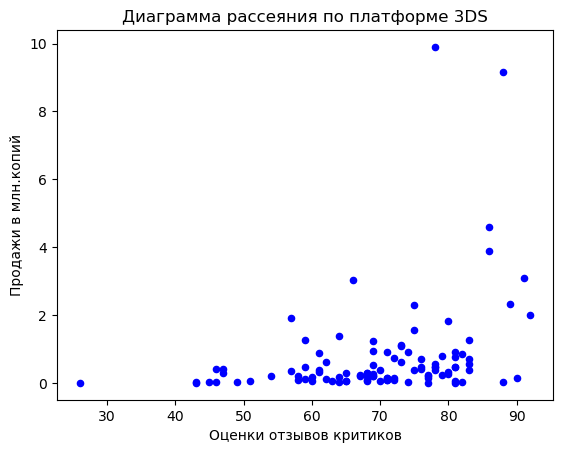

Расчет по Платформе DS
Для платформы DS не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей
Для платформы DS не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
Расчет по Платформе PC


user_score   -0.121867
total_sum     1.000000
Name: total_sum, dtype: float64

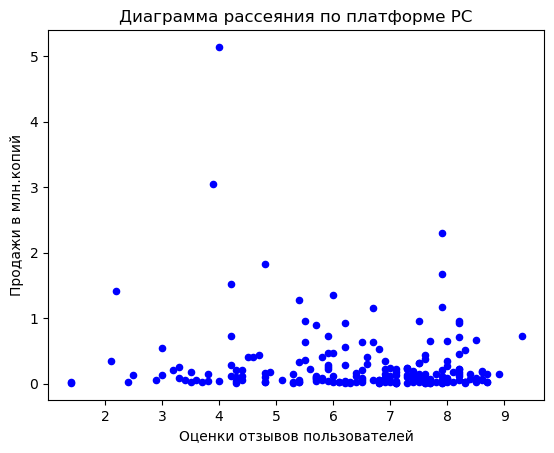

critic_score    0.237243
total_sum       1.000000
Name: total_sum, dtype: float64

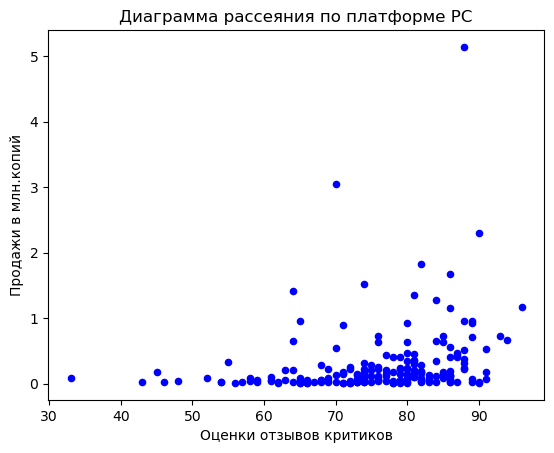

Расчет по Платформе PS3


user_score   -0.006206
total_sum     1.000000
Name: total_sum, dtype: float64

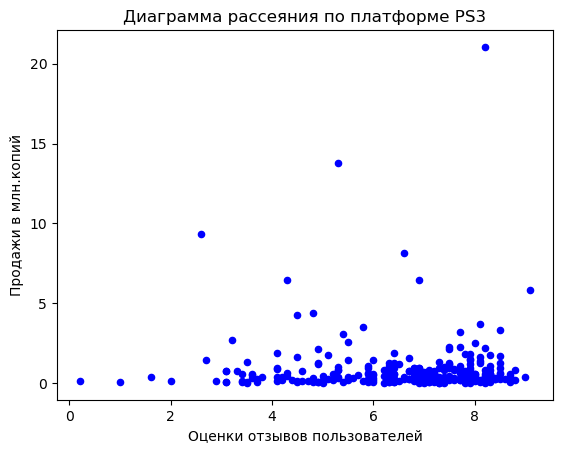

critic_score    0.334152
total_sum       1.000000
Name: total_sum, dtype: float64

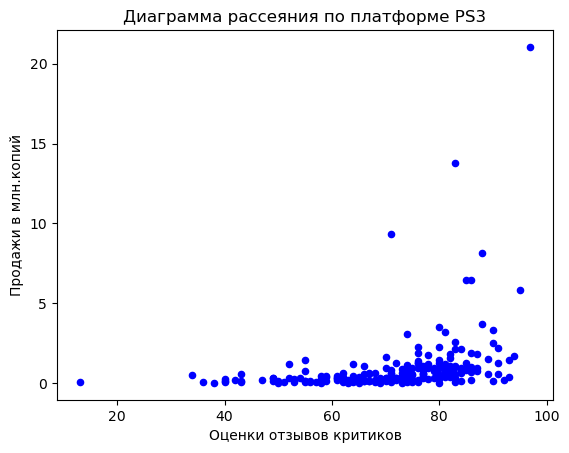

Расчет по Платформе PS4


user_score   -0.031957
total_sum     1.000000
Name: total_sum, dtype: float64

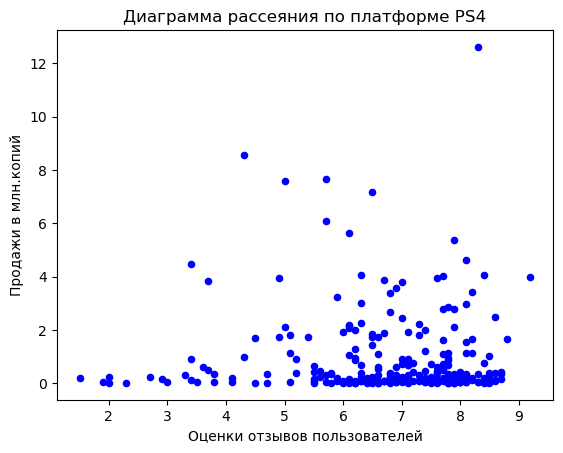

critic_score    0.406568
total_sum       1.000000
Name: total_sum, dtype: float64

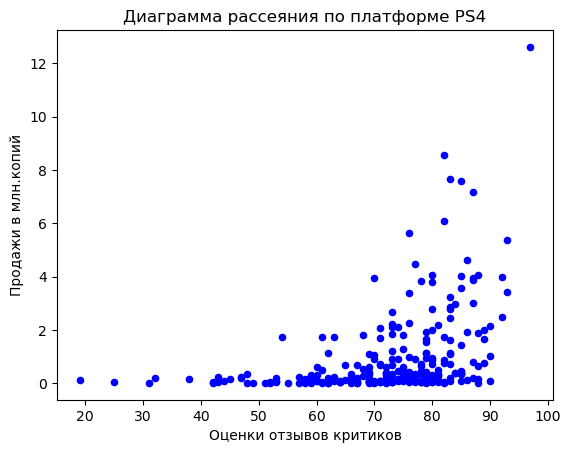

Расчет по Платформе PSP


user_score   -0.802302
total_sum     1.000000
Name: total_sum, dtype: float64

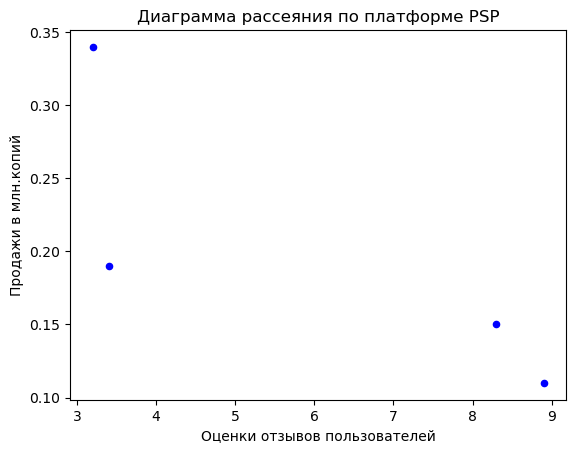

Для платформы PSP не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
Расчет по Платформе PSV


user_score   -0.004339
total_sum     1.000000
Name: total_sum, dtype: float64

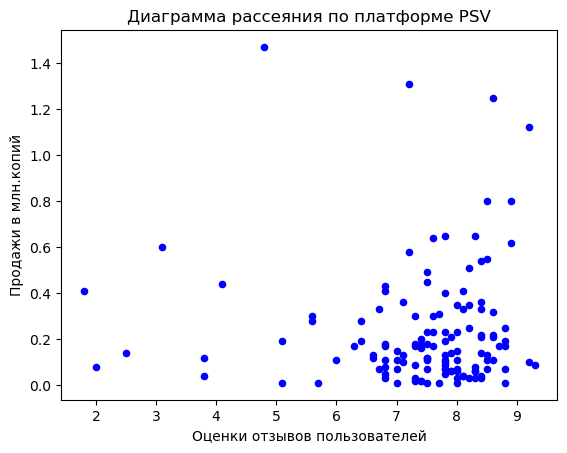

critic_score    0.094488
total_sum       1.000000
Name: total_sum, dtype: float64

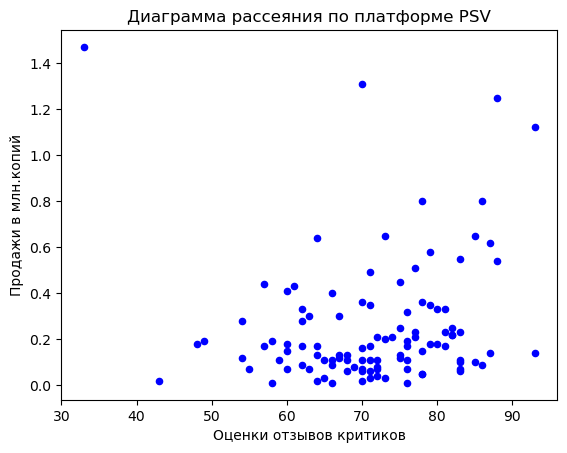

Расчет по Платформе Wii


user_score    0.296197
total_sum     1.000000
Name: total_sum, dtype: float64

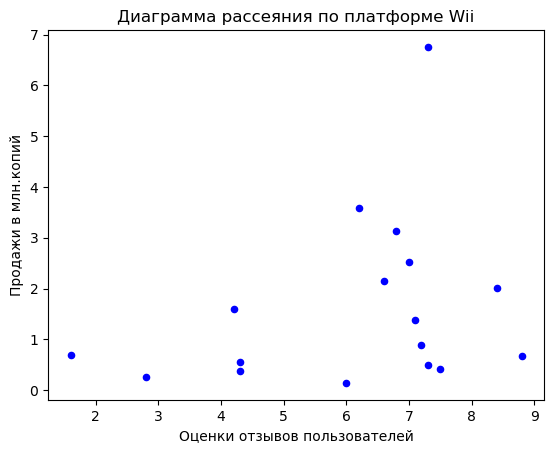

critic_score   -0.424341
total_sum       1.000000
Name: total_sum, dtype: float64

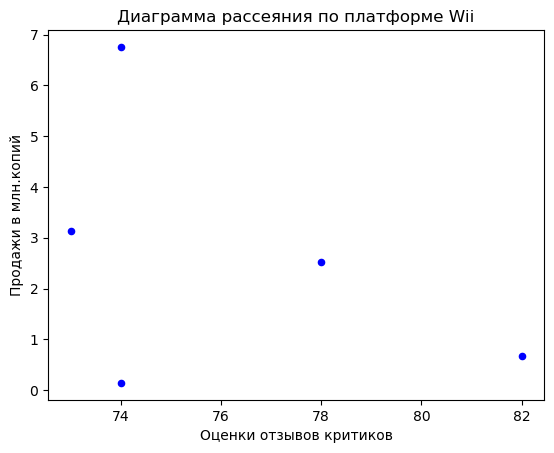

Расчет по Платформе WiiU


user_score    0.400219
total_sum     1.000000
Name: total_sum, dtype: float64

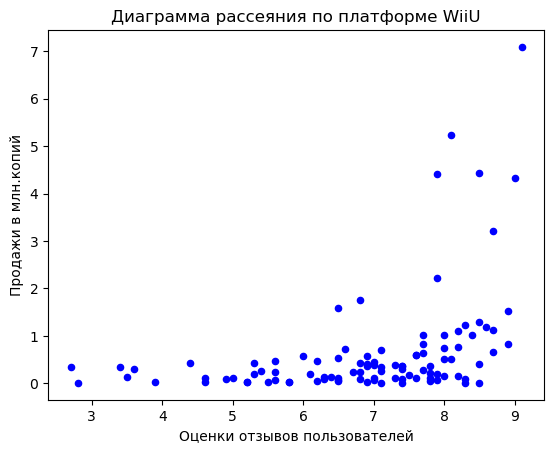

critic_score    0.34838
total_sum       1.00000
Name: total_sum, dtype: float64

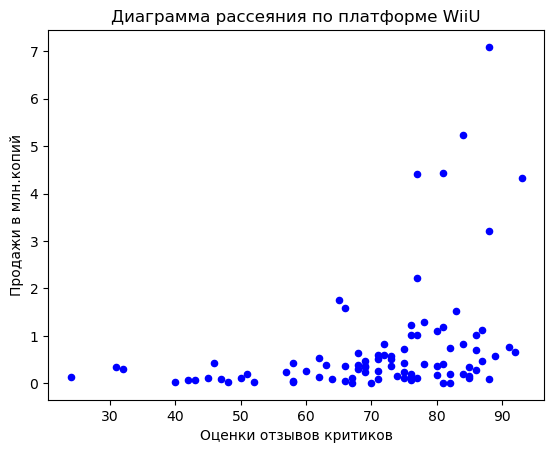

Расчет по Платформе X360


user_score    0.006164
total_sum     1.000000
Name: total_sum, dtype: float64

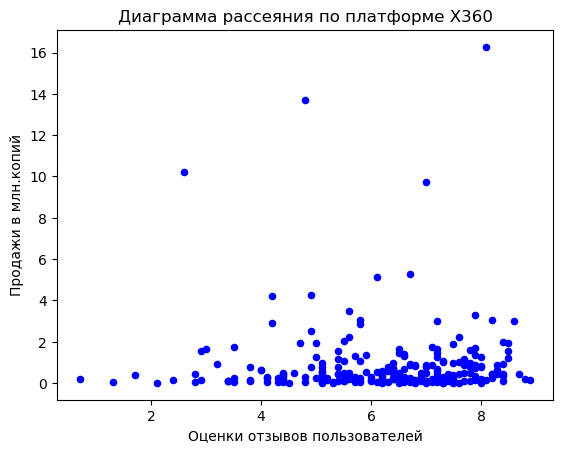

critic_score    0.360573
total_sum       1.000000
Name: total_sum, dtype: float64

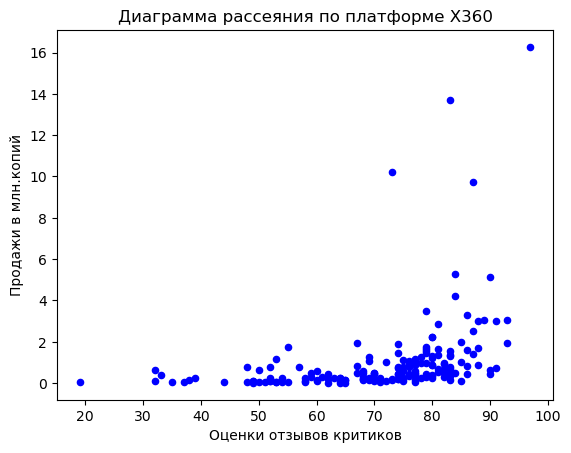

Расчет по Платформе XOne


user_score   -0.068925
total_sum     1.000000
Name: total_sum, dtype: float64

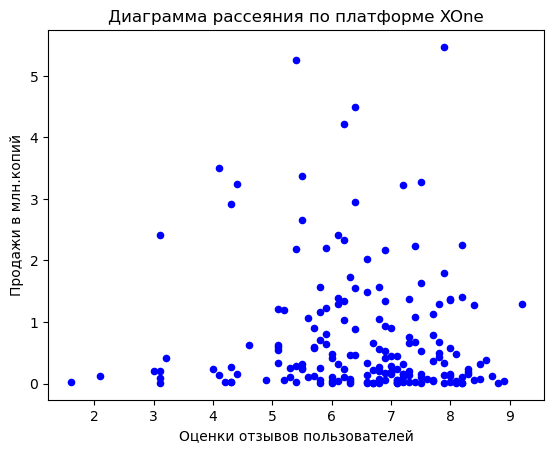

critic_score    0.416998
total_sum       1.000000
Name: total_sum, dtype: float64

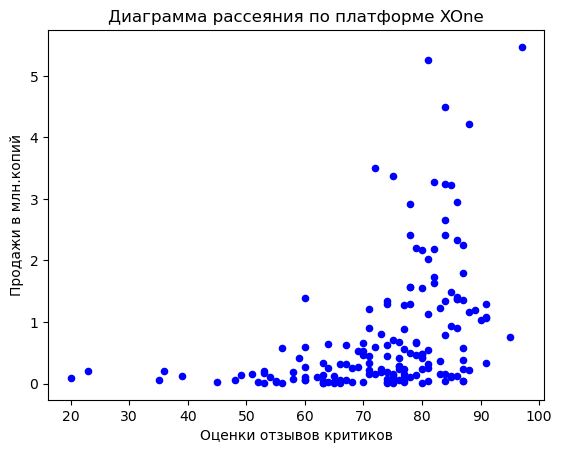

In [61]:
# Комментарий ревьюера 3
import matplotlib.pyplot as plt
df_sc, y = new_df.copy(), 'total_sum'
for platform, games_on_pl in df_sc.groupby('platform'):
    print('='*60)
    print('Расчет по Платформе',platform)
    # Считаем сколько в колонке не пустых отзывов
    not_user = len(games_on_pl[(games_on_pl.user_score != -1)&(games_on_pl['user_score'].notna() == True)])
    not_critic = len(games_on_pl[(games_on_pl.critic_score != -1)&(games_on_pl['user_score'].notna() == True)])
    sum_not = 3 # Задаем количество не пустых значений для вывода диаграммы и расчета корреляции
    if not_user > sum_not:
        games_on_pl[games_on_pl.user_score != -1].plot(kind='scatter', x='user_score', y=y, color='b')
        display(games_on_pl[games_on_pl.user_score != -1][['user_score', y]].corr()[y])
        plt.xlabel('Оценки отзывов пользователей')
        plt.ylabel('Продажи в млн.копий')
        plt.title('Диаграмма рассеяния по платформе '+platform)
        plt.show()
    else:
        print('Для платформы',platform, 'не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей')
    if not_critic > sum_not:
        games_on_pl[games_on_pl.critic_score != -1].plot(kind='scatter', x='critic_score', y=y, color='b')
        display(games_on_pl[games_on_pl.critic_score != -1][['critic_score', y]].corr()[y])
        plt.xlabel('Оценки отзывов критиков')
        plt.ylabel('Продажи в млн.копий')
        plt.title('Диаграмма рассеяния по платформе '+platform)
        plt.show()
    else:
        print('Для платформы',platform, 'не хватает данных для построения диаграммы и расчета корреляции отзывов критиков')

Коэффициент корреляции 0.40 - тут есть зависимость влияния оценок критиков на продажи игр на платформе PS4.

Рассмотрев зависимость между оценкой пользователей/критиков и продажами на примере 5-ти самых прибыльных платформах, можно сказать что оценки критиков могут влиять на продажи коэффициент корреляции тут на всех платформах высокий, а вот оценки пользователей практически ни на что не влияют, только на одной платформе WiiU коэффициент высокий - 0.4, на остальных 4-х платформах он  значительно меньше 0.1.

*Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?*

In [62]:
pop_genre = new_df.groupby('genre').agg({'name':'count'}).reset_index()
pop_genre.sort_values(by='name', ascending=False)

,genre,name
0,action,1031
7,role-playing,370
1,adventure,302
10,sports,267
8,shooter,235
3,misc,192
6,racing,115
2,fighting,109
4,platform,85
9,simulation,80


Самый популярный жанр в играх - 'action'

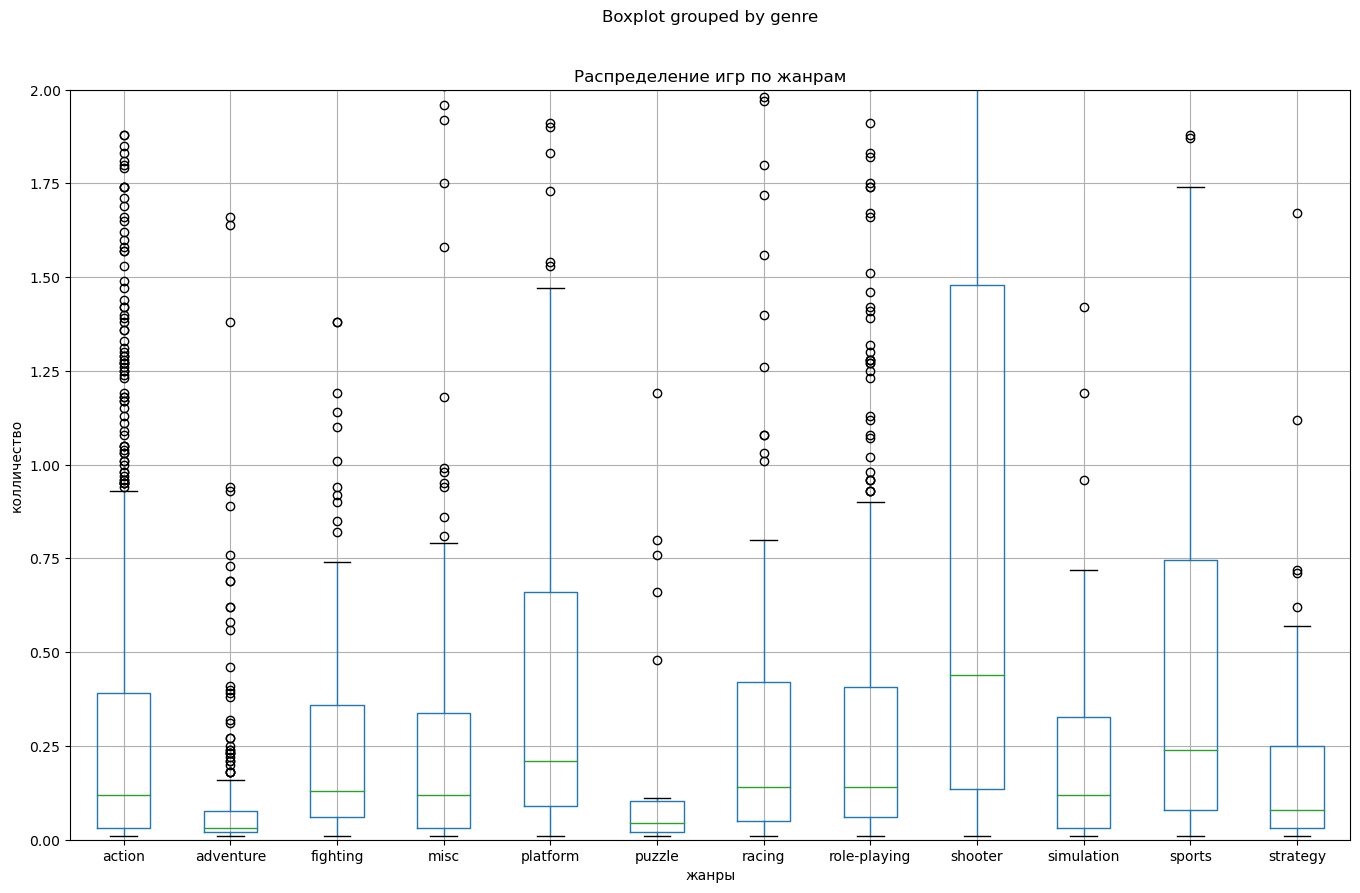

In [63]:
new_df.boxplot(column = ['total_sum'],by = ['genre'],figsize=(16, 10)).set(title = 'Распределение игр по жанрам', 
         xlabel = 'жанры', ylabel = 'колличество')
plt.ylim([0, 2])
plt.show()

Медианное значение продаж выше в жанре shooter. Второе место по медианным продажам делят platform и sports. В жанре action много выбросов, из-за этого общая прибыль по жанру action выше остальных.

### Шаг 4. Составьте портрет пользователя каждого региона

C:\Users\123\AppData\Local\Temp\ipykernel_4292\1349066264.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_platform = top_platform.append(pd.Series({'Другие': others}))
C:\Users\123\AppData\Local\Temp\ipykernel_4292\1349066264.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_platform = top_platform.append(pd.Series({'Другие': others}))
C:\Users\123\AppData\Local\Temp\ipykernel_4292\1349066264.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_platform = top_platform.append(pd.Series({'Другие': others}))


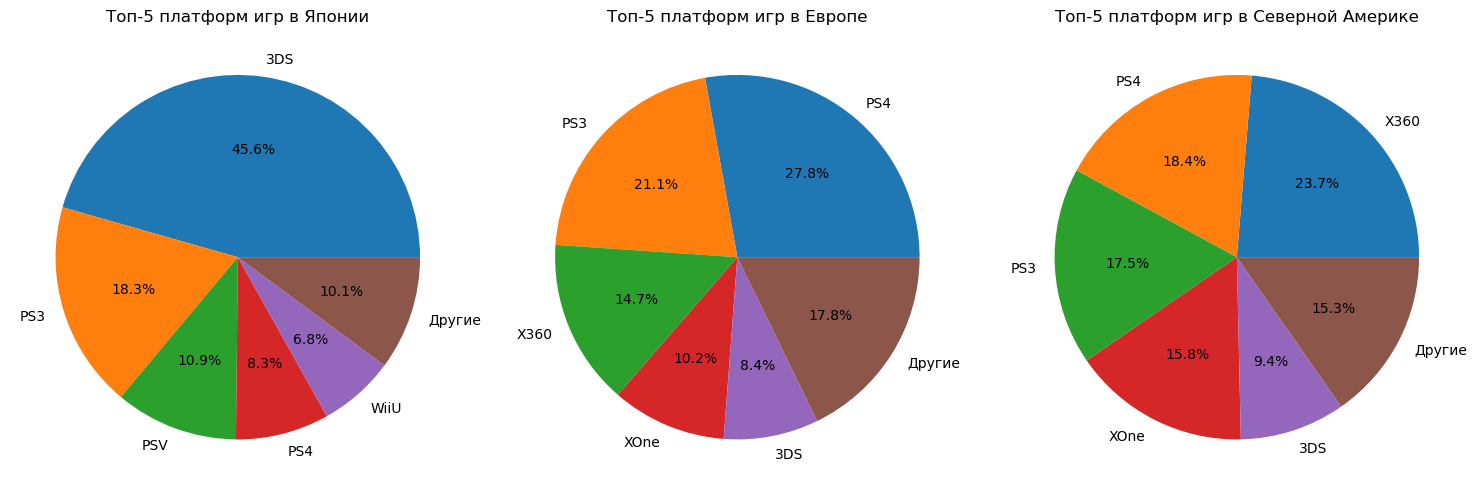

In [64]:
def plot_pie_top5_with_others(ax, region_sales, title):
    # Топ-5 платформ
    top_platform = region_sales.head(5)
    
    # Добавление строки "Другие" с суммой всех остальных платформ
    others = region_sales[~region_sales.index.isin(top_platform.index)].sum()
    top_platform = top_platform.append(pd.Series({'Другие': others}))
    
    # Построение круговой диаграммы
    top_platform.plot(kind='pie', autopct='%1.1f%%', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('')

# Создание подграфиков
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Топ-5 платформ игр в Японии
jp_top_platform = new_df.groupby(by='platform')['jp_sales'].sum().sort_values(ascending=False)
plot_pie_top5_with_others(axes[0], jp_top_platform, 'Топ-5 платформ игр в Японии')

# Топ-5 платформ игр в Европе
eu_top_platform = new_df.groupby(by='platform')['eu_sales'].sum().sort_values(ascending=False)
plot_pie_top5_with_others(axes[1], eu_top_platform, 'Топ-5 платформ игр в Европе')

# Топ-5 платформ игр в Северной Америке
na_top_platform = new_df.groupby(by='platform')['na_sales'].sum().sort_values(ascending=False)
plot_pie_top5_with_others(axes[2], na_top_platform, 'Топ-5 платформ игр в Северной Америке')

plt.tight_layout()
plt.show()

Рассмотрим самые популярные платформы по регионам, в Японии это 3DS, в Европе - PS4, в Северной Америке - X360. Менее популярные по странам Япония - WiiU, Европа - 3DS, Северная Америка - 3DS. Eсли рассмотреть какие именно платформы попали в Топ-5, то список в Европе и Северной Америке идентичен, а вот в Японии отличие в том что платформа X360, вообще не вошла в топ, зато в Японии в топ вошла платформа WiiU котороя не вошла в топ в других двух регионах. При этом все остальные платформы которые не вошли в топ, суммарно на них приходится в Японии 10%, в Европе - 17.8%, в Северной Америке 15.3%. 

C:\Users\123\AppData\Local\Temp\ipykernel_4292\3330669052.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_genres = top_genres.append(pd.Series({'Другие': others}))
C:\Users\123\AppData\Local\Temp\ipykernel_4292\3330669052.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_genres = top_genres.append(pd.Series({'Другие': others}))
C:\Users\123\AppData\Local\Temp\ipykernel_4292\3330669052.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_genres = top_genres.append(pd.Series({'Другие': others}))


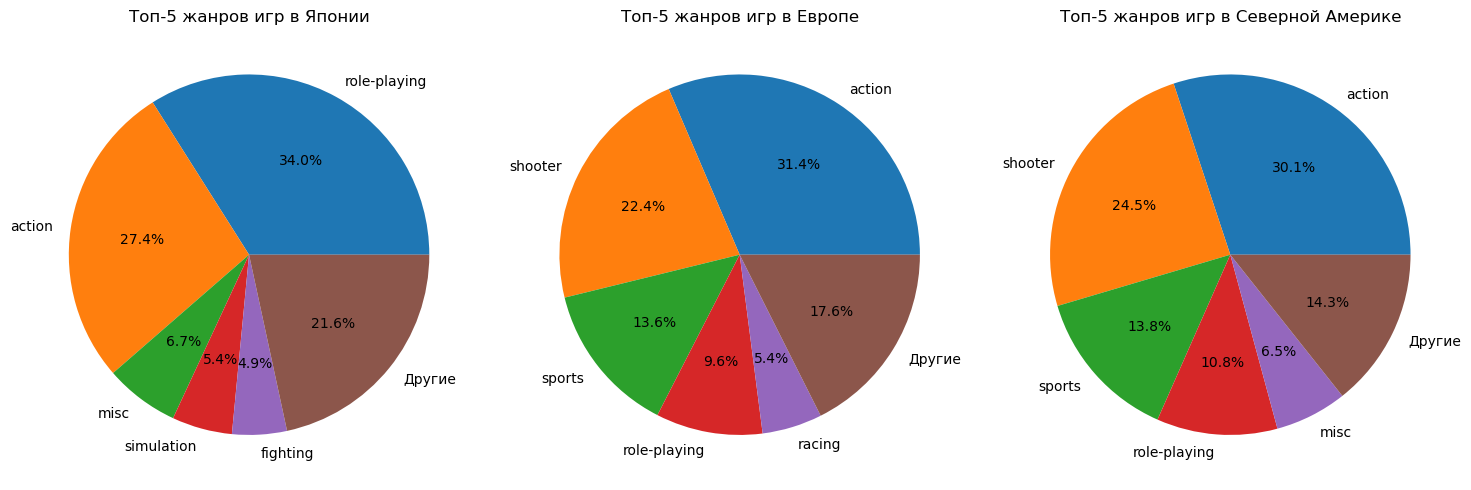

In [65]:
def plot_pie_top5_with_others(ax, region_sales, title):
    # Топ-5 жанров
    top_genres = region_sales.head(5)
    
    # Добавление строки "Другие" с суммой всех остальных жанров
    others = region_sales[~region_sales.index.isin(top_genres.index)].sum()
    top_genres = top_genres.append(pd.Series({'Другие': others}))
    
    # Построение круговой диаграммы
    top_genres.plot(kind='pie', autopct='%1.1f%%', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('')

# Создание подграфиков
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Топ-5 жанров игр в Японии
jp_top_genres = new_df.groupby(by='genre')['jp_sales'].sum().sort_values(ascending=False)
plot_pie_top5_with_others(axes[0], jp_top_genres, 'Топ-5 жанров игр в Японии')

# Топ-5 жанров игр в Европе
eu_top_genres = new_df.groupby(by='genre')['eu_sales'].sum().sort_values(ascending=False)
plot_pie_top5_with_others(axes[1], eu_top_genres, 'Топ-5 жанров игр в Европе')

# Топ-5 жанров игр в Северной Америке
na_top_genres = new_df.groupby(by='genre')['na_sales'].sum().sort_values(ascending=False)
plot_pie_top5_with_others(axes[2], na_top_genres, 'Топ-5 жанров игр в Северной Америке')

plt.tight_layout()
plt.show()

Рассмотрим топ-5 популярных жанров игр по регионам. Список жанров в Европе и Северной Америке практически идентичен, на первом месте жанр - action, а вот последнее место в списке отличается, в Европе это - racing, в Северной Америке - misc. В Японии же свой рейтинг на первом месте - role-playing, на последнем - fighting. Если посмотреть суммарно сколько по продажам занимают другие жанры, то в Японии - 21.6%, В Европе - 17.6%, в Северной Америке - 14.3% 

C:\Users\123\AppData\Local\Temp\ipykernel_4292\2074756110.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_rating = top_rating.append(pd.Series({'Другие': others}))
C:\Users\123\AppData\Local\Temp\ipykernel_4292\2074756110.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_rating = top_rating.append(pd.Series({'Другие': others}))
C:\Users\123\AppData\Local\Temp\ipykernel_4292\2074756110.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_rating = top_rating.append(pd.Series({'Другие': others}))


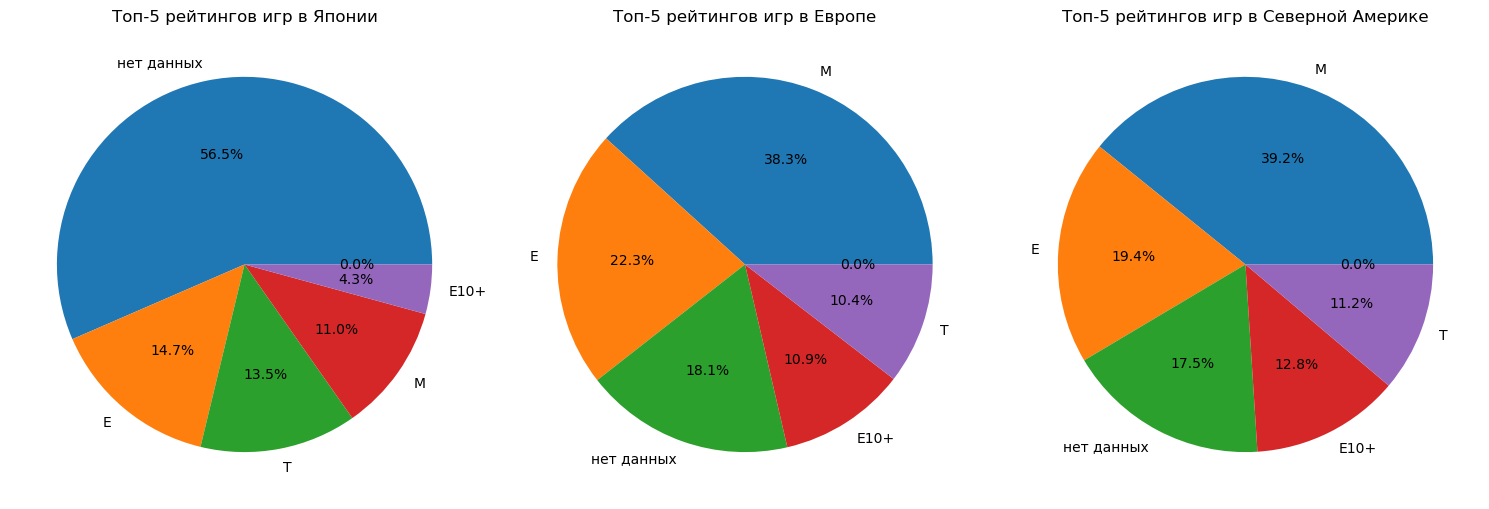

In [66]:
def plot_pie_top5_with_others(ax, region_sales, title):
    # Топ-5 рейтингов
    top_rating = region_sales.head(5)
    
    # Добавление строки "Другие" с суммой всех остальных рейтингов
    others = region_sales[~region_sales.index.isin(top_rating.index)].sum()
    top_rating = top_rating.append(pd.Series({'Другие': others}))
    
    # Построение круговой диаграммы
    top_rating.plot(kind='pie', autopct='%1.1f%%', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('')

# Создание подграфиков
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Топ-5 рейтингов игр в Японии
jp_top_rating = new_df.groupby(by='rating')['jp_sales'].sum().sort_values(ascending=False)
plot_pie_top5_with_others(axes[0], jp_top_rating, 'Топ-5 рейтингов игр в Японии')

# Топ-5 рейтингов игр в Европе
eu_top_rating = new_df.groupby(by='rating')['eu_sales'].sum().sort_values(ascending=False)
plot_pie_top5_with_others(axes[1], eu_top_rating, 'Топ-5 рейтингов игр в Европе')

# Топ-5 рейтингов игр в Северной Америке
na_top_rating = new_df.groupby(by='rating')['na_sales'].sum().sort_values(ascending=False)
plot_pie_top5_with_others(axes[2], na_top_rating, 'Топ-5 рейтингов игр в Северной Америке')

plt.tight_layout()
plt.show()

Теперь изучим как влияет рейтинг игр на продажи по регионам. В Северной Америке и Европе на первом месте рейтинг M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет, на втором месте «E» («Everyone») — «Для всех», на последнем в «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. И опять же топ -5 рейтингов по этим двум регионам полностью совпадает. В Японии же на первом месте находяться игры у которых не определен рейтинг, это обусловлено так же тем что компания ESRB которая устанавливает рейтинги на игры, работает на территории США и Канады, Японский рынок она не затрагивает. На последнем же месте по продажам в Японии находиться рейтинг «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»  

In [67]:
# Комментарий ревьюера
temp = new_df.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

0 0.0


нет данных    1275
M              498
T              412
E              394
E10+           306
Name: rating, dtype: int64

### Шаг 5. Проверьте гипотезы

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.



**Гипотеза 1**
*Сформулируем нулевую и анльтернативную гипотезы:*

- Н0: Средний пользовательский рейтинг платформ Xbox One и PC одинаковый
- H1: Средний пользовательский рейтинг платформ Xbox One и PC различается


Так как наши выборки независимы между собой будем использовать t-критерий Стьюдента

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, правильно сформулированы гипотезы.</font>

In [68]:
#зададим alpha
alpha = .05

#введём 2 переменных с данными оценок по Xbox One и PC
xbox_one = new_df[(new_df['platform'] == 'XOne') & (new_df['user_score'] > 0)]['user_score']
pc = new_df[(new_df['platform'] == 'PC') & (new_df['user_score'] > 0)]['user_score']

#проведём тест
results = st.ttest_ind(xbox_one, pc)

#выведем результат
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза звучала так - 'Средний пользовательский рейтинг платформ Xbox One и PC одинаковый'. Проведя двусторонний t-тест, нулевую гипотезу не получилось отвергнуть, значит рейтинг платформ Xbox One и PC одинаковый.

**Гипотеза 2**
*Сформулируем нулевую и альтернативную гипотезы:*

- H0: Средние пользовательские рейтинги жанров action и sports равны
- H1: Средние пользовательские рейтинги жанров action и sports различаются


Здесь так же будем использовать t-критерий Стьюдента


In [69]:
#введём 2 переменных с данными оценок по жанру  action и sports
action = new_df[(new_df['genre'] == 'action') & (new_df['user_score'] > 0)]['user_score']
sport = new_df[(new_df['genre'] == 'sports') & (new_df['user_score'] > 0)]['user_score']

#проведём тест
results = st.ttest_ind(action, sport)

#выведем результат
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.804523380462917e-26
Отвергаем нулевую гипотезу


Нулевая гипотеза звучала так - 'Средние пользовательские рейтинги жанров action и sports равны'. Проведя двусторонний t-тест, нулевую гипотеза была отвергнута, значит средние пользовательские рейтинги жанров action и sports не равны.

Поддержаны первая и вторая гипотезы.

Платформа XOne продолжает усиливать свои позиции и привлекать новых пользователей, не только конкурируя с PS4, но и стараясь превзойти самую распространенную платформу на планете - ПК. Качество игр на XOne в 2016 году приближается к компьютерным играм.

Различия между жанрами action и sports обусловлены опытом их создания. Первые action игры появились в 80-х годах, и с каждым годом они становятся все более интересными, так как разработчикам есть на что равняться в прошлом. У игр в жанре sport, в большинстве случаев, ограничение связано с необходимостью симулировать реальные спортивные события. Любителям данного жанра иногда приходится сталкиваться с неоднозначными решениями в таких играх.

## Вывод

Цель проета для интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры, было выявить определяющие успешность игры закономерности, что позволило бы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Нужно было на основе данных определить актуальный период и по нему этого спланировать компанию на 2017год.

В рамках анализа датасета о продажах видеоигр были проведены следующие шаги: выявлены и обработаны пропуски, удалены дубликаты, преобразованы типы данных в столбцах, добавлен новый столбец 'total_sum' с суммарными продажами по регионам. Анализ актуального периода (2012-2016 годы) показал, что наиболее перспективными платформами являются PS4 и XOne.

Рассмотрев зависимость между оценкой пользователей/критиков и продажами на примере 5-ти самых прибыльных платформах, можно сказать что оценки критиков могут влиять на продажи коэффициент корреляции тут на всех платформах высокий, а вот оценки пользователей практически ни на что не влияют, только на одной платформе WiiU коэффициент высокий - 0.4, на остальных 4-х платформах он  значительно меньше 0.1.
Далее были рассмотрены самые прибыльные жанры, в результате чего было выявлено, что жанры Shooter, Platform и Sports занимают лидирующие позиции по медианным продажам.

Самые популярные платформы по регионам: 
- Япония - 3DS
- Европа - PS4
- Северной Америке - X360

Менее популярные по регионам:
- Япония - WiiU
- Европа - 3DS
- Северная Америка - 3DS

Eсли рассмотреть какие именно платформы попали в Топ-5, то список в Европе и Северной Америке идентичен, а вот в Японии отличие в том что платформа X360, вообще не вошла в топ, зато в Японии в топ вошла платформа WiiU котороя не вошла в топ в других двух регионах. 
Анализ предпочтений по регионам показал, что существуют различия в предпочтениях игроков в Японии, Европе и Северной Америке. 

Самые популярные жанры игр по регионам:
- Европа и Северная Америка - action
- Япония  - role-playing 

Изучили влияние рейтинга игр на продажи по регионам:
Северноая Америка и Европа  - на первом месте рейтинг M» («Mature») — «Для взрослых», 
на втором месте «E» («Everyone») — «Для всех»
В Японии - на первом месте игры у которых не определен рейтинг, это обусловлено так же тем что компания ESRB которая устанавливает рейтинги на игры, работает на территории США и Канады, японский рынок она не затрагивает. 

В заключении, были проверены две гипотезы: о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковы, и о том, что средние пользовательские рейтинги жанров Action и Sports различаются. Обе гипотезы подтвердились. Выводы проекта могут быть полезны для планирования маркетинговой стратегии и выбора платформ и жанров для разработки новых игр.

Однако следует помнить, что рынок игровой индустрии постоянно меняется, и чтобы принять наиболее эффективные решения, необходимо проводить дополнительные исследования и анализ. Анализ потенциальной аудитории, ее предпочтений и трендов поможет глубже понять спрос на игры и создать продукт, который будет привлекательным для пользователей. Непрерывное изучение рынка поможет быть в курсе последних изменений и трендов, что в свою очередь способствует успешному планированию и разработке игр.